In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

data_dir_full = db.query('sess_name=="e15_13f1_220117"')['data_dir_full'][0]

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


load *SessionPulses.Events.mat failed


In [4]:
reload(dpp)
beh_df=dpp.get_multi_maze_behavior_df(behavior)
beh_df = beh_df.reset_index()

In [29]:

from scipy.signal import butter, filtfilt,medfilt

In [95]:
dt = 0.033
beh_df['vx_raw'] = np.gradient(beh_df['x']) / dt
beh_df['vy_raw'] = np.gradient(beh_df['y']) /dt
beh_df['speed_raw'] = np.sqrt(beh_df['vx_raw']**2 + beh_df['vy_raw']**2)

In [96]:
from data_prep_pyn import butter_lowpass_filtfilt

In [97]:
fs = 1/dt
cutoff = 1.
beh_df['vx_butter'] = butter_lowpass_filtfilt(beh_df['vx_raw'],cutoff,fs,order=1)
beh_df['vy_butter'] = butter_lowpass_filtfilt(beh_df['vy_raw'],cutoff,fs,order=1)

beh_df['speed_butter'] = np.sqrt(beh_df['vx_butter']**2 + beh_df['vy_butter']**2)

In [98]:
win = 11 
beh_df['vx_mm'] = medfilt(beh_df['vx_raw'],win)
beh_df['vy_mm'] = medfilt(beh_df['vy_raw'],win)

beh_df['speed_mm'] = np.sqrt(beh_df['vx_mm']**2 + beh_df['vy_mm']**2)

In [99]:
from scipy.ndimage import gaussian_filter1d
win = 9 
beh_df['vx_ma'] = gaussian_filter1d(beh_df['vx_raw'],win)
beh_df['vy_ma'] = gaussian_filter1d(beh_df['vy_raw'],win)

beh_df['speed_ma'] = np.sqrt(beh_df['vx_ma']**2 + beh_df['vy_ma']**2)

In [106]:
reload(dpp)
dpp.get_speed_gaussian(beh_df[['x','y']].values,win_size=0.3)

(array([[ 3.79593311, -4.28660668],
        [ 3.84340623, -4.29316351],
        [ 3.93705568, -4.30558576],
        ...,
        [-1.64406373,  6.40071299],
        [-1.69191358,  6.50943302],
        [-1.71630914,  6.56443703]]),
 array([5.72574057, 5.76220656, 5.83425026, ..., 6.60848487, 6.72571854,
        6.78509768]))

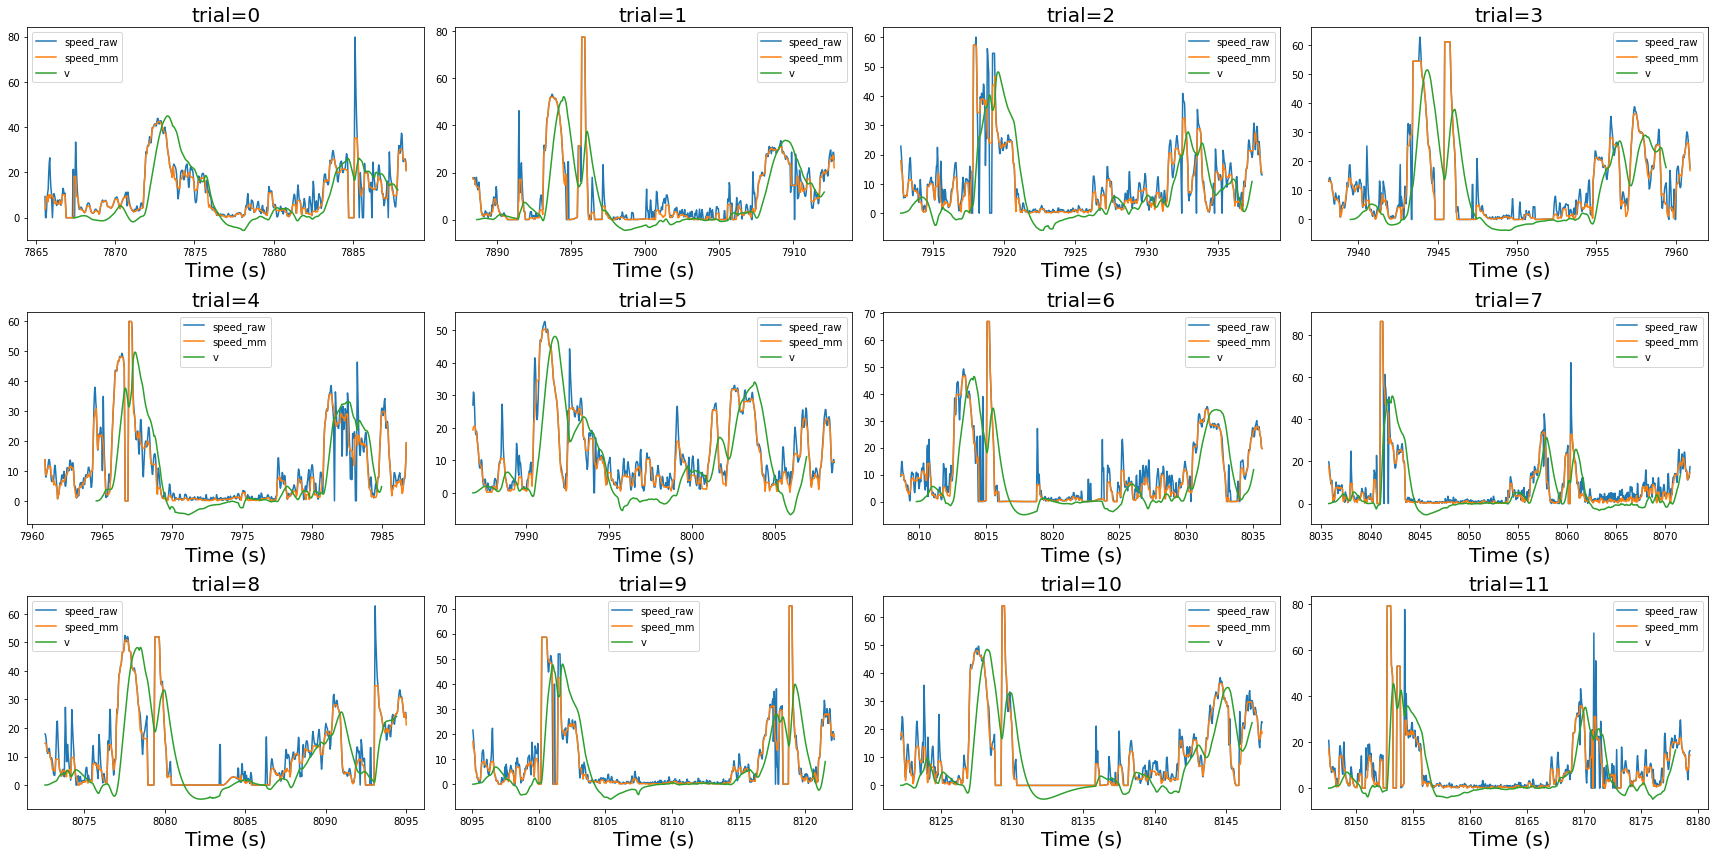

In [100]:
%matplotlib inline
fig,axs = ph.subplots_wrapper(12)
tr_l = range(12)
for ii,tr in enumerate(tr_l):
    ax = axs.ravel()[ii]
    beh_df.query('task_index==0&trial==@tr')[['speed_raw','speed_mm','v']].plot(ax=ax)
    ax.set_title(f'trial={tr}')
plt.tight_layout()

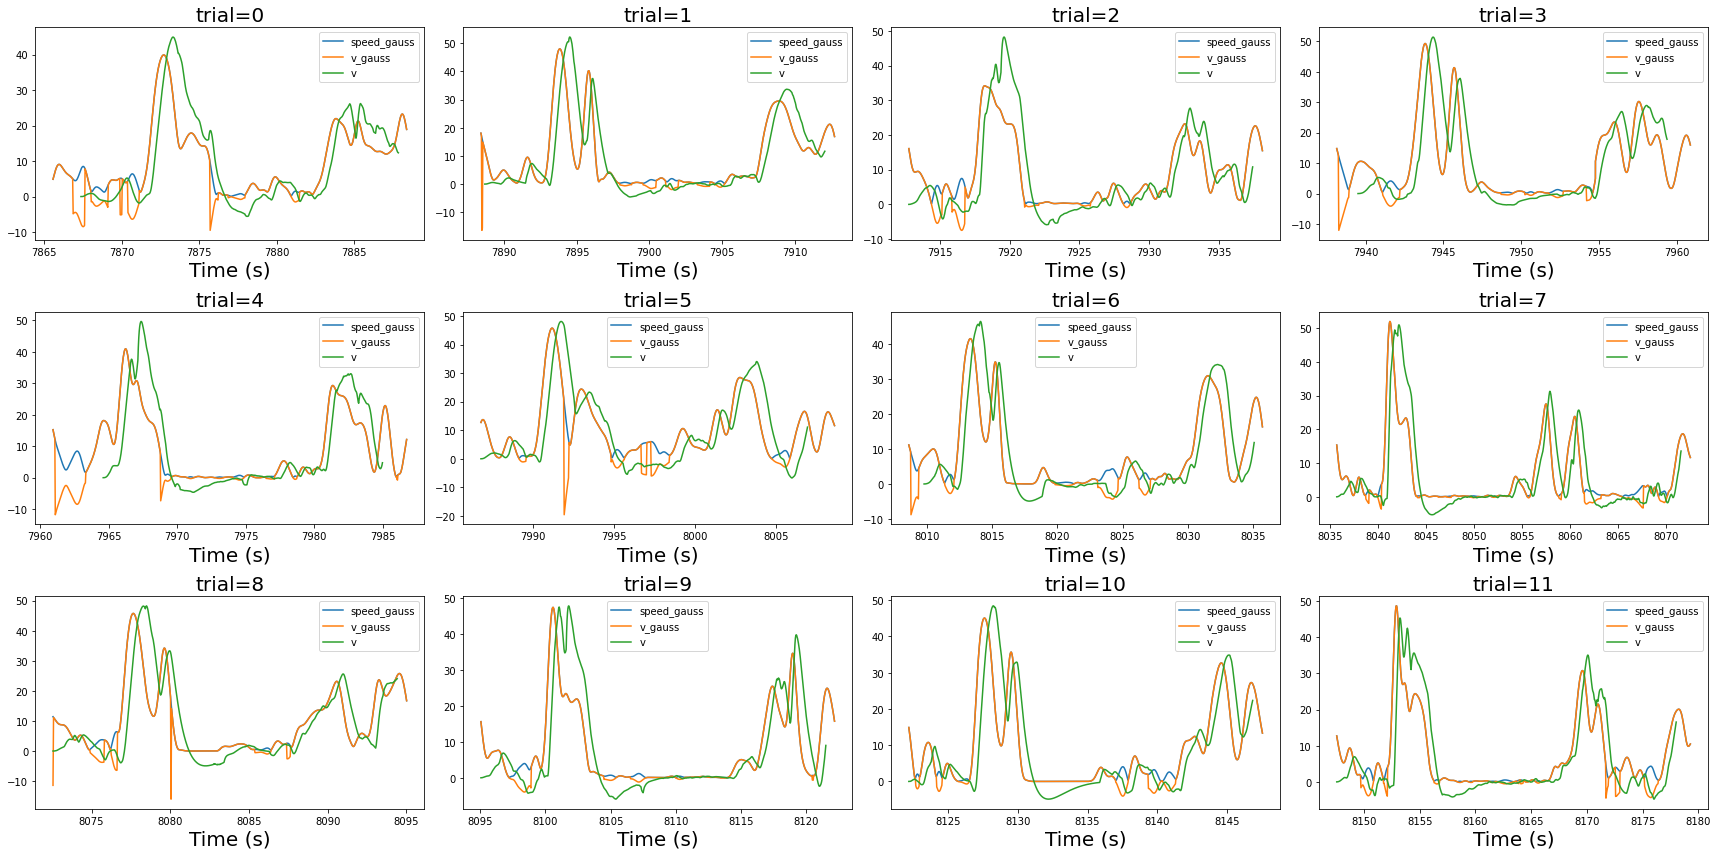

In [115]:
fig,axs = ph.subplots_wrapper(12)
tr_l = range(12)
for ii,tr in enumerate(tr_l):
    ax = axs.ravel()[ii]
    beh_df.query('task_index==0&trial==@tr')[['speed_gauss','v_gauss','v']].plot(ax=ax)
    ax.set_title(f'trial={tr}')
plt.tight_layout()

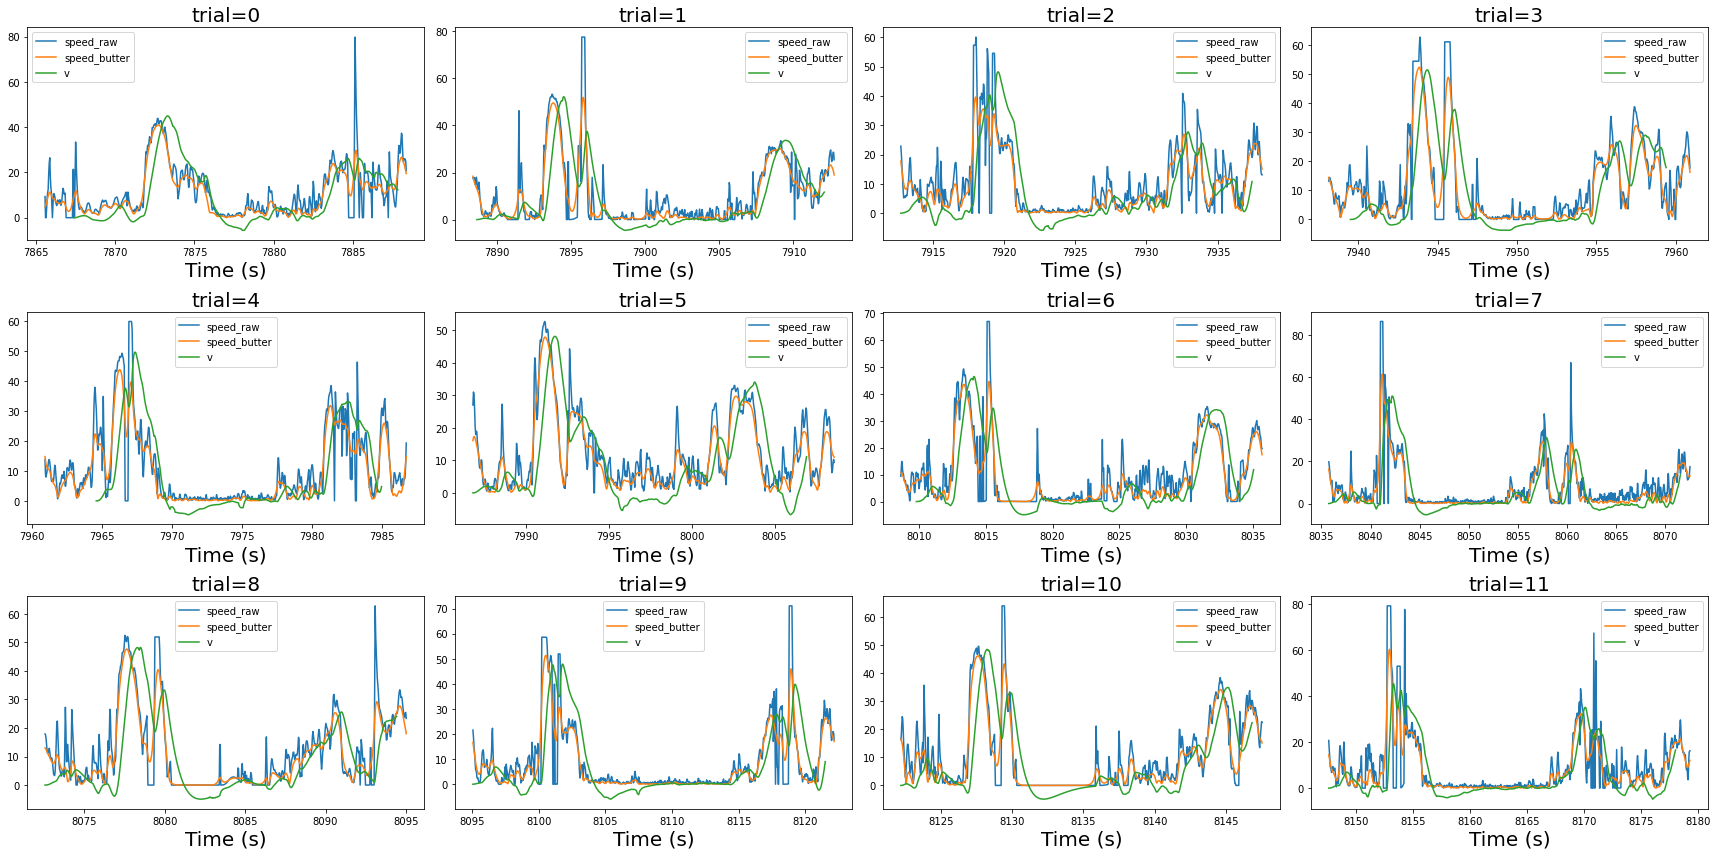

In [102]:
fig,axs = ph.subplots_wrapper(12)
tr_l = range(12)
for ii,tr in enumerate(tr_l):
    ax = axs.ravel()[ii]
    beh_df.query('task_index==0&trial==@tr')[['speed_raw','speed_butter','v']].plot(ax=ax)
    ax.set_title(f'trial={tr}')
plt.tight_layout()

In [51]:
from sklearn.metrics import confusion_matrix
def get_states_count_overlap(v_l,bins=(0,1,5,np.inf)):
    state_l = []
    c_l = {}
    for v in v_l:
        state=pd.cut(v,bins,labels=False,retbins=False,include_lowest=True)
        state_l.append(state)

    for i in range(len(v_l)-1):
        for j in range(i+1,len(v_l)):
            c = confusion_matrix(state_l[i],state_l[j])
            c_l[(i,j)] = c
     
    return c_l
        

In [92]:
beh_df_sub = beh_df

<IPython.core.display.Javascript object>


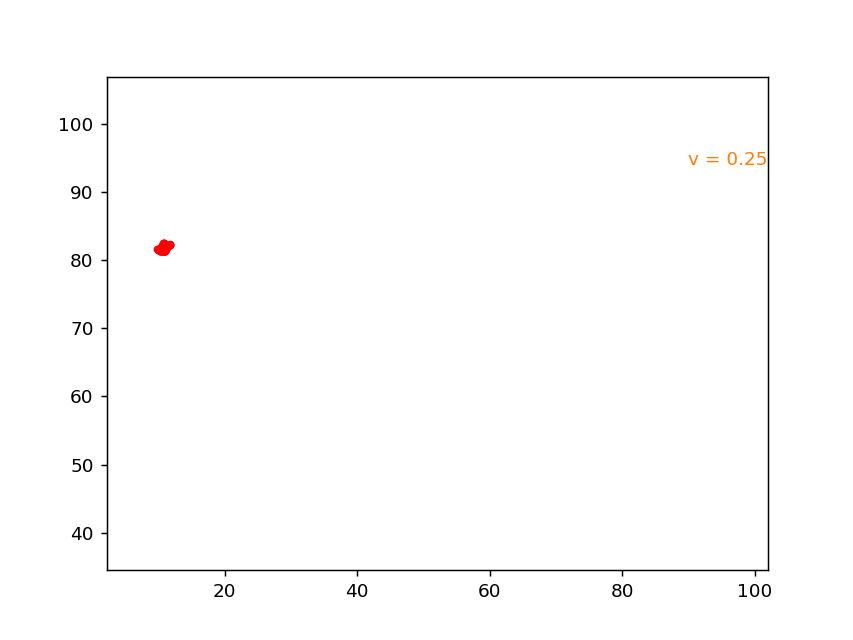

In [93]:
%matplotlib notebook
# %%time


import animate_helper as ah
reload(ah)
tr=9
one_chunk = beh_df_sub.query('task_index==0&trial==@tr')
data = one_chunk[['x','y']].values.T
x_all = beh_df_sub['x'].values
y_all = beh_df_sub['y'].values
# speed_l = one_chunk['speed_oef'].values
# speed_l = one_chunk['speed_butter'].values
speed_l = one_chunk['speed_ma'].values
save_dir = os.path.join(data_dir_full,'py_figures','behavior')
DO_SAVE=False

save_fn = f'behavior_trial{tr}.mp4'

fig,ax,ani=ah.animate_movement_in_maze(data,x_all,y_all,hist2d_kws={},ax_kws={},fig=None,ax=None,
                                    animate_kws={'interval':100},dosave=DO_SAVE,
                                    do_plot_background_maze=False,
                                    n_tail=100,trial_l=None,speed_l=speed_l,
                                    save_dir=save_dir,save_fn=save_fn
                                )

In [129]:
beh_df=beh_df.reset_index()

# headscan detection again!

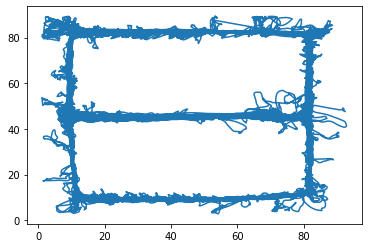

In [141]:
plt.plot(beh_df['x'],beh_df['y'])

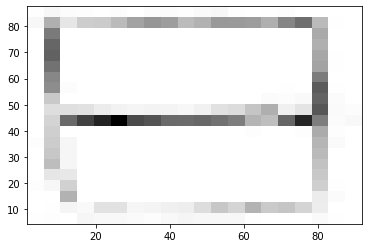

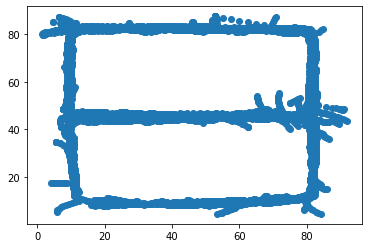

In [156]:
beh_df_highspeed=beh_df.query('speed_gauss>10')
plt.hist2d(beh_df_highspeed['x'],beh_df_highspeed['y'],bins=20)
plt.figure()
plt.scatter(beh_df_highspeed['x'],beh_df_highspeed['y'])

In [23]:
beh_df['vx_norm']=beh_df['vx_gauss']/beh_df['speed_gauss']
beh_df['vy_norm']=beh_df['vy_gauss']/beh_df['speed_gauss']

In [217]:
nbins = 20
beh_df['x_bin'],x_bins = pd.cut(beh_df['x'],nbins,labels=False,retbins=True)
beh_df['y_bin'],y_bins = pd.cut(beh_df['y'],nbins,labels=False,retbins=True)

In [218]:
beh_df['xy_bin']= pd.Categorical(list(zip(beh_df['x_bin'],beh_df['y_bin'])))

In [262]:
# get time spent in a bin
speed_key = 'speed_gauss'
dt = 0.033
counter = 0
counter_l = []
expected_dist_l = []
expected_dist = 0

for i, ((_,row1),(_,row2)) in enumerate(zip(beh_df.iloc[:-1].iterrows(),beh_df.iloc[1:].iterrows())):    
    counter_l.append(counter)
    expected_dist_l.append(expected_dist)
    if row1['xy_bin'] != row2['xy_bin']:
        counter = 0
        expected_dist = 0
    else:
        counter = counter + 1
        expected_dist = expected_dist + row1[speed_key] * dt
counter_l.append(counter)
expected_dist_l.append(expected_dist)
beh_df['counter'] = counter_l
beh_df['expected_dist'] = expected_dist_l

In [266]:
max_time_per_bin_trial = beh_df.groupby(['trial','xy_bin'])['counter'].max()
max_expected_dist_per_bin_trial = beh_df.groupby(['trial','xy_bin'])['expected_dist'].max()

ValueError: not enough values to unpack (expected 2, got 1)

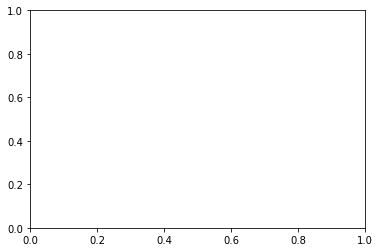

In [245]:
xys = np.array([list(x) for x in max_time_per_bin_trial.loc[0].index])
plt.pcolormesh(xys[:,0],xys[:,1],max_time_per_bin_trial.values)

In [252]:
xys.shape

(210, 2)

<AxesSubplot:>

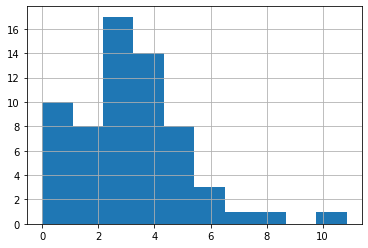

In [272]:
max_expected_dist_per_bin_trial.loc[2].hist()

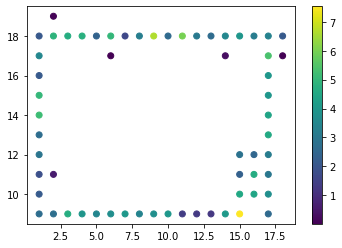

In [273]:
# data=max_time_per_bin_trial.loc[0].dropna()
data = max_expected_dist_per_bin_trial.loc[0].dropna()
xys = np.array([list(x) for x in data.index])
plt.scatter(xys[:,0],xys[:,1],c=data.values,cmap='viridis')
plt.colorbar()

In [274]:
one_chunk = beh_df.query('trial==0')

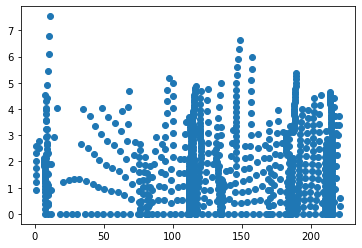

In [279]:
plt.scatter(one_chunk['lin'],one_chunk['expected_dist'])

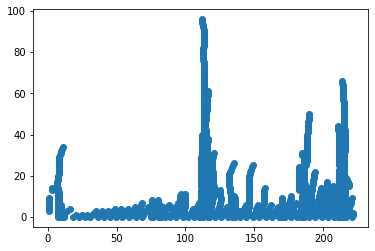

In [280]:
plt.scatter(one_chunk['lin'],one_chunk['counter'])

In [275]:
max_time_per_bin_trial = beh_df.groupby(['trial','xy_bin'])['counter'].max()
max_expected_dist_per_bin_trial = beh_df.groupby(['trial','xy_bin'])['expected_dist'].max()

lin          x          y  trial  task_index         task  \
Time (s)                                                                        
6603.331633    3.131094  77.813737  47.715979    0.0           0  alternation   
6603.364967    3.131094  77.822900  47.884739    0.0           0  alternation   
6603.398300  218.728170  77.803383  48.183710    0.0           0  alternation   
6603.431667  218.374458  77.719991  48.587112    0.0           0  alternation   
6603.465000  217.843891  77.663467  49.099355    0.0           0  alternation   
...                 ...        ...        ...    ...         ...          ...   
6644.175333    0.805138  80.164806  45.103043    0.0           0  alternation   
6644.208667    0.894598  80.054142  45.193974    0.0           0  alternation   
6644.242000    0.984058  79.982340  45.280659    0.0           0  alternation   
6644.275333    0.894598  80.009005  45.242266    0.0           0  alternation   
6644.308700    0.715679  80.182840  45.081924    0.0           0  alternation   

             vx_gauss   vy_gauss  speed_gauss  visitedArm  ...  trial_type  \
Time (s)                                                   ...               
6603.331633 -0.046853   8.673098     8.673224         0.0  ...    (0, 0.0)   
6603.364967 -0.221547   9.173868     9.176543         0.0  ...    (0, 0.0)   
6603.398300 -0.401516   9.632039     9.640404         0.0  ...    (0, 0.0)   
6603.431667 -0.588496  10.029833    10.047083         0.0  ...    (0, 0.0)   
6603.465000 -0.783562  10.349941    10.379560         0.0  ...    (0, 0.0)   
...               ...        ...          ...         ...  ...         ...   
6644.175333 -0.332336  -8.381175     8.387761         0.0  ...    (0, 0.0)   
6644.208667 -0.098311  -8.377258     8.377834         0.0  ...    (0, 0.0)   
6644.242000  0.126815  -8.441489     8.442442         0.0  ...    (0, 0.0)   
6644.275333  0.335024  -8.565938     8.572487         0.0  ...    (0, 0.0)   
6644.308700  0.518994  -8.740643     8.756038         0.0  ...    (0, 0.0)   

               v_gauss  segment x_bin  y_bin    xy_bin   vx_norm   vy_norm  \
Time (s)                                                                     
6603.331633   8.673224      0.0    16     10  (16, 10) -0.005402  0.999985   
6603.364967  -9.176543      3.0    16     10  (16, 10) -0.024143  0.999709   
6603.398300  -9.640404      3.0    16     10  (16, 10) -0.041649  0.999132   
6603.431667 -10.047083      3.0    16     10  (16, 10) -0.058574  0.998283   
6603.465000 -10.379560      3.0    16     10  (16, 10) -0.075491  0.997146   
...                ...      ...   ...    ...       ...       ...       ...   
6644.175333   8.387761      3.0    17      9   (17, 9) -0.039622 -0.999215   
6644.208667   8.377834      3.0    17      9   (17, 9) -0.011735 -0.999931   
6644.242000   8.442442      3.0    17      9   (17, 9)  0.015021 -0.999887   
6644.275333   8.572487      3.0    17      9   (17, 9)  0.039081 -0.999236   
6644.308700   8.756038      3.0    17      9   (17, 9)  0.059273 -0.998242   

            counter  expected_dist  
Time (s)                            
6603.331633      13       2.496037  
6603.364967      14       2.782253  
6603.398300      15       3.085079  
6603.431667      16       3.403213  
6603.465000      17       3.734766  
...             ...            ...  
6644.175333       5       1.480063  
6644.208667       6       1.756859  
6644.242000       7       2.033328  
6644.275333       8       2.311928  
6644.308700       9       2.594820  

[1230 rows x 23 columns]

In [255]:
max_time_per_bin_trial

trial  xy_bin  
0.0    (0, 0)       NaN
       (0, 3)       NaN
       (0, 6)       NaN
       (0, 7)       NaN
       (0, 8)       NaN
                   ... 
34.0   (19, 8)      6.0
       (19, 9)     21.0
       (19, 10)    28.0
       (19, 18)     NaN
       (19, 19)     NaN
Name: counter, Length: 7350, dtype: float64

In [ ]:
beh_df['counter']

In [282]:
import networkx as nx

# Example time series of positions as tuples (x, y)
time_series = beh_df['xy_bin'].values

# Record the transitions between consecutive positions
transitions = [(time_series[i], time_series[i + 1]) for i in range(len(time_series) - 1)]

# Count the frequency of each unique transition
transition_freq = {}
for transition in transitions:
    if transition[0]!= transition[1]:
        if transition not in transition_freq:
            transition_freq[transition] = 0
        transition_freq[transition] += 1

# Create a directed graph and add the positions as nodes
G = nx.DiGraph()
G.add_nodes_from(set(time_series))

# Add directed edges with weights corresponding to transition frequencies
for transition, frequency in transition_freq.items():
    G.add_edge(transition[0], transition[1], weight=frequency)



In [296]:
# Get the edges that meet the weight threshold
edges_subset = [(u, v) for u, v, data in G.edges(data=True) if data['weight'] >= 5]

# Create a subgraph using the selected edges
G_thresholded = G.edge_subgraph(edges_subset)

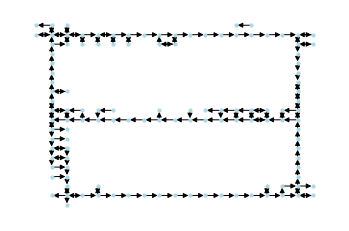

In [297]:
# pos = nx.spring_layout(G)
# pos = nx.spectral_layout(G)
G_ = G_thresholded

pos = {k:np.array(k) for k in G_.nodes}
fig,ax= plt.subplots()
nx.draw(G_, pos, with_labels=False, node_size=10, node_color="lightblue",ax=ax)
# ax.set_xlim([0,10])
# ax.set_ylim([60,90])
# plt.show()

In [205]:
pos

{(26, 21): array([26, 21]),
 (7, 35): array([ 7, 35]),
 (18, 35): array([18, 35]),
 (30, 0): array([30,  0]),
 (8, 18): array([ 8, 18]),
 (21, 37): array([21, 37]),
 (19, 18): array([19, 18]),
 (30, 18): array([30, 18]),
 (0, 23): array([ 0, 23]),
 (33, 20): array([33, 20]),
 (33, 29): array([33, 29]),
 (4, 2): array([4, 2]),
 (34, 3): array([34,  3]),
 (10, 36): array([10, 36]),
 (33, 38): array([33, 38]),
 (2, 32): array([ 2, 32]),
 (34, 12): array([34, 12]),
 (3, 6): array([3, 6]),
 (22, 19): array([22, 19]),
 (34, 21): array([34, 21]),
 (3, 15): array([ 3, 15]),
 (34, 30): array([34, 30]),
 (3, 24): array([ 3, 24]),
 (22, 37): array([22, 37]),
 (3, 33): array([ 3, 33]),
 (37, 35): array([37, 35]),
 (7, 3): array([7, 3]),
 (18, 3): array([18,  3]),
 (26, 16): array([26, 16]),
 (38, 18): array([38, 18]),
 (18, 21): array([18, 21]),
 (8, 4): array([8, 4]),
 (30, 4): array([30,  4]),
 (19, 4): array([19,  4]),
 (29, 36): array([29, 36]),
 (6, 34): array([ 6, 34]),
 (33, 24): array([33,

In [202]:
np.array(G.nodes)

array([[26, 21],
       [ 7, 35],
       [18, 35],
       ...,
       [ 3, 38],
       [15,  3],
       [26,  3]])

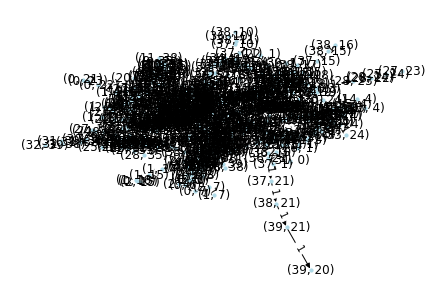

In [197]:
# Example: visualize the graph using NetworkX and Matplotlib
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=10, node_color="lightblue")
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [28]:
gpb = beh_df.query('speed_gauss>4').groupby(['x_bin','y_bin'])
median_vxy_per_bin = gpb[['vx_norm','vy_norm']].median()


xy_bin_timebincount = gpb.count().iloc[:,0] 

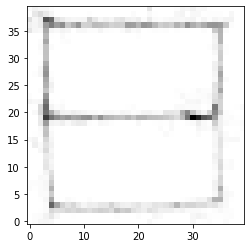

In [30]:
xy_2d_hist = xy_bin_timebincount.unstack().T
plt.imshow(xy_2d_hist,origin='lower')

In [167]:
kde=scipy.stats.gaussian_kde(beh_df.query('speed_gauss>5')[['x','y']].T,0.01)

In [71]:
x_grid =np.arange(0,90,1)
y_grid =np.arange(0,90,1)
X,Y = np.mgrid[,0:90:1]

In [72]:
meshpoints = np.stack([X.ravel(),Y.ravel()],axis=1).T


In [168]:
xy_2d_kde=kde(meshpoints).reshape(X.shape)

In [150]:
xy_2d_kde

array([[6.11746126e-06, 7.80602859e-06, 9.66630180e-06, ...,
        7.30375402e-05, 6.34731332e-05, 5.34784603e-05],
       [8.13366497e-06, 1.04231468e-05, 1.29661115e-05, ...,
        8.94649448e-05, 7.75661596e-05, 6.51965311e-05],
       [1.05400920e-05, 1.35678623e-05, 1.69583283e-05, ...,
        1.07197048e-04, 9.26875467e-05, 7.76918077e-05],
       ...,
       [7.89247512e-06, 1.09622017e-05, 1.49028554e-05, ...,
        5.77836109e-05, 4.51394591e-05, 3.41136992e-05],
       [6.67205730e-06, 9.21116933e-06, 1.24505668e-05, ...,
        4.74041310e-05, 3.70509713e-05, 2.80182205e-05],
       [5.52757489e-06, 7.58323220e-06, 1.01873886e-05, ...,
        3.79965510e-05, 2.97358550e-05, 2.25181723e-05]])

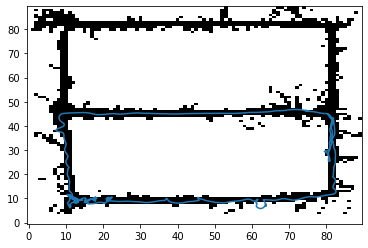

In [169]:
thresh = 1e-4
plt.pcolormesh(X,Y,xy_2d_kde>thresh)
one_chunk = beh_df.query('trial==1')
plt.plot(one_chunk['x'],one_chunk['y'])

In [170]:
# Calculate the gradient of the KDE
pdf = xy_2d_kde
# x_grid=X
# y_grid=Y
pdf_x, pdf_y = np.gradient(pdf, x_grid, y_grid)

# Compute the Hessian using second-order finite differences
pdf_xx, pdf_xy = np.gradient(pdf_x, x_grid, y_grid)
pdf_yx, pdf_yy = np.gradient(pdf_y, x_grid, y_grid)


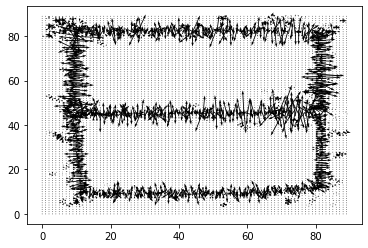

In [171]:
plt.quiver(X.ravel(),Y.ravel(),pdf_x.ravel(),pdf_y.ravel(),angles='xy')

In [172]:
pdf_hessian = np.stack([np.stack([pdf_xx,pdf_xy],axis=-1),np.stack([pdf_yx, pdf_yy],axis=-1)],axis=-2)

In [174]:
ep_thresh =1e-9
zero_det=np.linalg.det(pdf_hessian) < ep_thresh
nonzero_trace = np.trace(pdf_hessian,axis1=-2,axis2=-1) > ep_thresh

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


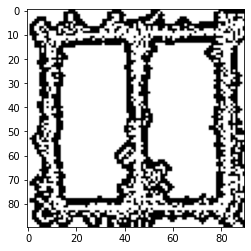

In [175]:
plt.imshow(zero_det&nonzero_trace)

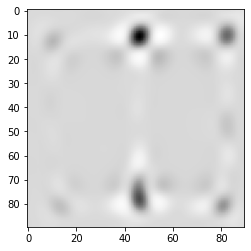

In [106]:
plt.imshow()

In [96]:
np.linalg.det(pdf_hessian[:,:,0,0])

-3.4434732718974854e-13

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import skimage
from skimage.feature import peak_local_max

# Generate some example data
np.random.seed(42)
x = np.random.normal(3, 1, 1000)
y = x * 2 + np.random.normal(0, 1, 1000)

# Compute the 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=50)

# Smooth the histogram using a Gaussian filter
smoothed_hist = ndi.gaussian_filter(hist, sigma=1)

# Find the local maxima in the smoothed histogram
local_maxima = peak_local_max(smoothed_hist, min_distance=1)

# Connect the local maxima to form a continuous ridge (this could be done using various algorithms)
# Here, we simply sort the local maxima by their x-coordinates
ridge_points = np.array(sorted(local_maxima, key=lambda x: x[1]))

# Extract the coordinates of the ridge points
ridge_x = xedges[ridge_points[:, 1]] + 0.5 * (xedges[1] - xedges[0])
ridge_y = yedges[ridge_points[:, 0]] + 0.5 * (yedges[1] - yedges[0])

# Visualize the 2D histogram and the 1D ridge
plt.imshow(hist.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.plot(ridge_x, ridge_y, 'r-', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram and 1D Ridge')
plt.show()


ModuleNotFoundError: No module named 'skimage'

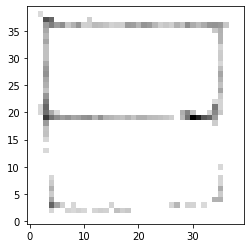

In [42]:
plt.imshow(xy_2d_hist*(xy_2d_hist>60),origin='lower')

<AxesSubplot:xlabel='Time (s)'>

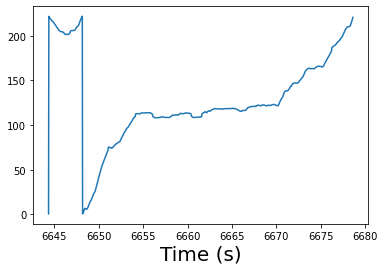

In [250]:
beh_df.query('trial==1')['lin'].plot()

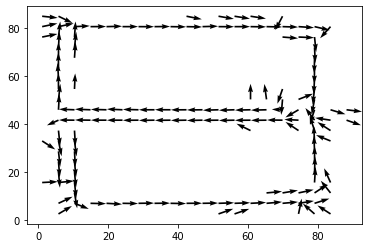

In [247]:
fig,ax=plt.subplots()
xx = x_bins[median_vxy_per_bin.index.get_level_values(0)]
yy = y_bins[median_vxy_per_bin.index.get_level_values(1)]
ax.quiver(xx,yy,median_vxy_per_bin['vx_norm'],median_vxy_per_bin['vy_norm'],
          angles='xy'
         )

In [ ]:
# first: get track geometry, seperate on track and off track, (then based on off track, can trace to get weird movements




In [302]:
smth_win = 41
beh_df['x_smth'] = scipy.signal.medfilt(beh_df['x'],smth_win)
beh_df['y_smth'] = scipy.signal.medfilt(beh_df['y'],smth_win)


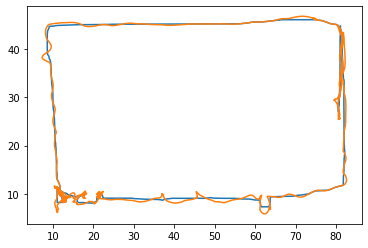

In [303]:
one_chunk = beh_df.query('trial==1')
plt.plot(one_chunk['x_smth'],one_chunk['y_smth'])
plt.plot(one_chunk['x'],one_chunk['y'])

In [308]:
import numpy as np

def sliding_window_mode_hist(data, window_size, num_bins=10):
    half_window = window_size // 2
    padded_data = np.pad(data, (half_window, half_window), 'edge')
    filtered_data = np.zeros_like(data)
    
    for i in range(len(data)):
        window = padded_data[i:i + window_size]
        hist, bin_edges = np.histogram(window, bins=num_bins)
        mode_index = np.argmax(hist)
        mode = (bin_edges[mode_index] + bin_edges[mode_index + 1]) / 2
        filtered_data[i] = mode
        
    return filtered_data

# Example usage
data = np.array([1, 2, 3, 3, 3, 4, 5, 1, 1, 1, 6])
window_size = 5
filtered_data = sliding_window_mode_hist(data, window_size)
print(filtered_data)


[1 1 2 3 3 3 1 1 1 1 5]


In [309]:
%%time
sliding_window_mode_hist(beh_df['x'],11)

CPU times: user 5.43 s, sys: 134 ms, total: 5.57 s
Wall time: 5.42 s


array([70.57882561, 70.58811973, 70.5651417 , ..., 92.38951646,
       92.38951646, 92.38974466])

In [310]:
def hist_get_max(x):
    np.histogram()
    
    
beh_df.rolling(window=5).apply()

Rolling [window=5,center=False,axis=0,method=single]

In [6]:
import cv2

In [7]:
cv2

<module 'cv2' from '/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/cv2/__init__.py'>

In [17]:
def detect_maze_edges(x_bin,y_bin):
    # Create an empty image to draw the maze edges
    height = y_bin.max()+1
    width = x_bin.max()+1
    img = np.zeros((height, width), np.uint8)

    # Draw the preprocessed points on the image
    for x,y in zip(x_bin, y_bin):
        img[int(x), int(y)] = 255

    # Apply the Canny edge detection algorithm
    edges = cv2.Canny(img, 100, 200)
    return edges

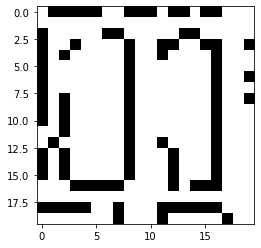

In [19]:
edges=detect_maze_edges(beh_df['x_bin'],beh_df['y_bin'])
plt.imshow(edges)

In [251]:
median_vxy_per_bin

vx_norm   vy_norm
x_bin y_bin                    
0     3      0.996955  0.077981
      7      0.727059 -0.686425
      17     0.959709  0.280995
      18     0.956132  0.292937
      19     0.988544 -0.150890
...               ...       ...
18    9     -0.976999  0.212752
      10     0.916428 -0.400200
      18    -0.525879 -0.850210
19    9      0.873614 -0.443914
      10     0.984814 -0.173596

[144 rows x 2 columns]

# detect headscan for real

In [5]:
reload(dpp)
corners_d,xy_sampled_d,segment_d=dpp.find_tmaze_turns(beh_df,n_lin=200,speed_key='speed_gauss',speed_thresh=10.)




In [126]:
def linefit(xy,thresh=1e-1):
    x = xy[:,0]
    y = xy[:,1]
    stdx = np.std(x)
    stdy = np.std(y)
    if stdx < thresh*stdy:
        A = 1
        B = 0
        C = -x[0]
    elif stdy < thresh*stdx:
        A = 0
        B = 1
        C = -y[0]
    else:
    # Perform TLS using SVD
        data = xy
        mean_data = np.mean(data, axis=0)
        centered_data = data - mean_data
        _, _, Vt = np.linalg.svd(centered_data)
        v = Vt[-1]
        A, B = v[:2]
        C = -np.dot(v[:2], mean_data)
    return (A,B,C)

In [262]:
def linefit_with_direction(xy,thresh=1e-1,corner_median_number=5):
#     p0 = np.median(xy[0:corner_median_number],axis=0)
    p0 = np.mean(xy,axis=0) # use the mean
    xy_ = xy - p0[None,:]
    x = xy_[:,0]
    y = xy_[:,1]
    stdx = np.std(x)
    stdy = np.std(y)
    if stdx < thresh*stdy:
        dir_y = 1 if np.sign(y).sum() > 0 else -1
        D = np.array([0,dir_y])
    elif stdy < thresh*stdx:
        dir_x = 1 if np.sign(x).sum() > 0 else -1
        D = np.array([dir_x,0])
    else:
        data = xy_
        mean_data = np.mean(data, axis=0)
        centered_data = data - mean_data
        _, _, Vt = np.linalg.svd(centered_data)
        v = Vt[-1]
        # Calculate the direction vector D and normalize it
        D = np.array([v[1], -v[0]])
        D = D / np.linalg.norm(D)
        diff = np.diff(centered_data,axis=0)
        projection = np.dot(diff,D[:,None])
        if np.sign(projection).sum() < 0:
            D = -D
    return p0,D
    
    

(40.0, 90.0)

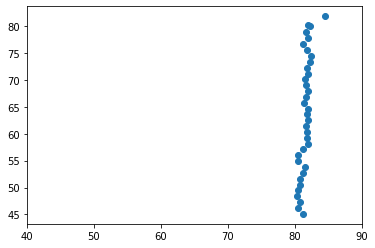

In [134]:
plt.scatter(xy_sampled_onesegment[:,0],xy_sampled_onesegment[:,1])
plt.xlim(40,90)

In [263]:
linefit_with_direction(xy_sampled_onesegment,thresh=1e-1)

(array([81.585, 63.553]), array([0, 1]))

In [132]:
linefit_with_direction(xy_sampled_onesegment,thresh=1e-1)

(array([81.91851261, 80.23005064]), array([ 0, -1]))

In [264]:
def get_segment_line(xy_sampled_d,segment_d,thresh=1e-1,corner_median_number=5):
    vec_l_d = {}
    
    for (k,xys),(k,seg) in zip(xy_sampled_d.items(),segment_d.items()):
        vec_l = []
        for s in np.unique(seg):
            data = xys[seg==s]
            p0,D=linefit_with_direction(data,thresh=thresh,corner_median_number=corner_median_number)
            vec_l.append([*p0,*D])
        vec_l = np.array(vec_l)
        vec_l_d[k] = vec_l
    return vec_l_d
        


In [309]:
np.tile([1,2,3],[5,1])

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [265]:
def get_dist_to_line(xy_l,pD):
    diff = xy_l[:,:2] - pD[:2]
    proj = np.dot(diff,pD[2:])
    dist = np.sqrt(np.linalg.norm(diff,axis=1)**2 - proj**2)
    return dist

In [317]:
corners_d

{(0,
  0.0):            x          y         lin
 0  80.659447  45.368996    0.000000
 1   8.441987  45.368996   74.655065
 2   8.441987  82.459683  110.310738
 3  80.659447  82.459683  183.850564
 4  80.659447  45.368996  221.734716,
 (0,
  1.0):            x          y         lin
 0  81.639861  45.681652    0.000000
 1  10.967778  45.681652   74.714610
 2  10.967778   9.716700  110.398722
 3  81.639861   9.716700  183.997203
 4  81.639861  45.681652  221.911572}

In [88]:
xy_sampled_d[0,1].shape

(236, 2)

In [89]:
segment_d[0,1].shape

(220,)

In [92]:
import behavior_analysis as ba
reload(ba)
corners_d,xy_sampled_d,segment_d=dpp.find_tmaze_turns(beh_df,n_lin=200,speed_key='speed_gauss',speed_thresh=10.)
line_pd_d = ba.get_segment_line(xy_sampled_d,segment_d,thresh=1e-1,corner_median_number=5)
xy_sampled_all, segment_all,line_pd_all=ba.combine_tmaze_turninfo(xy_sampled_d, segment_d,line_pd_d)

In [12]:
xy_l = beh_df[['x','y']].values

In [95]:
reload(ba)
dist_l = ba.get_dist_to_maze(xy_l,xy_sampled_all)

In [96]:
beh_df['dist_to_maze_thorough'] = dist_l

In [ ]:
get_dist_to_maze(xy_l,xy_sampled_all,segment_all,line_pd_all)

In [266]:
vec_l_d = get_segment_line(xy_sampled_d,segment_d,thresh=1e-1,corner_median_number=3)

In [267]:
vec_l_both = np.concatenate([vec_l_d[0,0],vec_l_d[0,1][1:]],axis=0)

In [268]:
vec_l_both

array([[45.406, 45.226,  1.   ,  0.   ],
       [ 9.577, 62.319,  0.   , -1.   ],
       [44.752, 82.301, -1.   ,  0.   ],
       [81.585, 63.553,  0.   ,  1.   ],
       [10.279, 27.073,  0.075, -0.997],
       [45.174,  9.426, -1.   ,  0.   ],
       [81.967, 28.174,  0.   , -1.   ]])

In [269]:
xy = beh_df[['x','y']].values
dist_all_seg = []
for pD in vec_l_both:
    dist = get_dist_to_line(xy,pD)
    dist_all_seg.append(dist)
dist_all_seg = np.array(dist_all_seg)
dist_all_seg = np.min(dist_all_seg,axis=0)
beh_df['dist_to_line_usemean'] = dist_all_seg

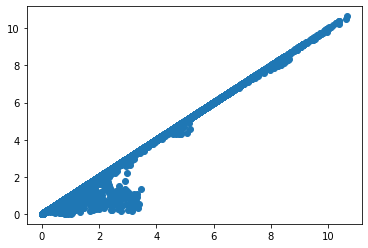

In [97]:
plt.scatter(beh_df['dist_to_maze'],beh_df['dist_to_maze_thorough'])

In [78]:
# fill in the gap
def fill_in_gap_xy_sample(xy_sampled_d,segment_d,gap_z_thresh = 1):
    '''
    sometimes the samples have gaps; fill them in by first detecting gaps i.e. consecutive points whose distances 
    are bigger than gap_z_thresh std, then do linear interpolation
    [NB!] if the gap occurs on the turns, would be problematic....
    '''
    segment_d_filled = {}
    xy_sampled_d_filled = {}
    for k,xys in xy_sampled_d.items():
        gaps = np.linalg.norm(np.diff(xys,axis=0),axis=1)
        expected_gap = gaps[gaps_z < 1].mean()
        gaps_z = scipy.stats.zscore(gaps)
        
        gap_ind = np.nonzero(gaps_z > gap_z_thresh)[0]


        segment_one = segment_d[k]
        for gi in gap_ind[::-1]:
            gap_size = gaps[gi]
            npts = int(gap_size / expected_gap)
            added_x = np.linspace(xys[gi,0],xys[gi+1,0],npts+2)
            added_y = np.linspace(xys[gi,1],xys[gi+1,1],npts+2)
            added_xy = np.stack([added_x,added_y],axis=1)
            xys = np.insert(xys,gi,added_xy,axis=0)
            seg_insert = np.array([segment_d[k][gi]] * npts)
            segment_one = np.insert(segment_one,gi,seg_insert)
        segment_d_filled[k] = segment_one
        xy_sampled_d_filled[k] =xys

    return xy_sampled_d_filled, segment_d_filled




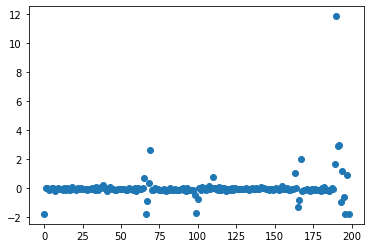

In [77]:
plt.scatter(np.arange(len(gaps_z)),gaps_z)

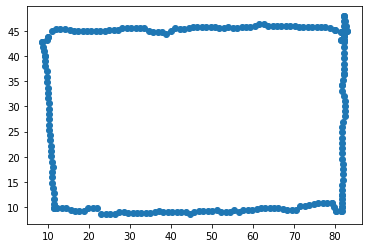

In [79]:
plt.scatter(xy_sampled_d_filled[0,1][:,0],xy_sampled_d_filled[0,1][:,1])

array([2.03202028, 2.04425966, 2.12479856, ..., 9.83500703, 9.94611057,
       9.99575083])

In [161]:
np.set_printoptions(suppress=True,precision=3)

In [303]:
val_filt=scipy.ndimage.median_filter(val,(5,1))

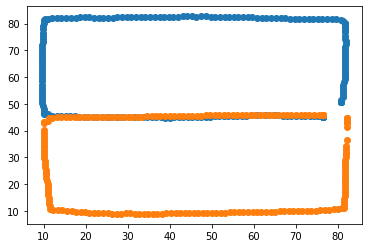

In [80]:
val_ = val_filt
for key, val in xy_sampled_d.items():
    val_filt=scipy.ndimage.median_filter(val,(20,1))
    val_ = val_filt
    plt.scatter(val_[:,0],val_[:,1])

In [18]:
xy_sampled_filt_d = {}
for k,val in xy_sampled_d.items():
    val_filt = scipy.ndimage.median_filter(val,(5,1))
    xy_sampled_filt_d[k] = val_filt

xy_sampled_filt_both = np.concatenate(list(xy_sampled_filt_d.values()),axis=0)

In [8]:
import behavior_analysis as ba
reload(ba)
xy_l = beh_df[['x','y']].values
xy_sampled_all = np.concatenate(list(xy_sampled_d.values()),axis=0)
dist = ba.get_dist_to_maze(xy_l,xy_sampled_all)
beh_df['dist_to_maze'] = dist

In [24]:
# from scipy.spatial.distance import cdist
# # dist_to_maze = np.min(cdist(beh_df[['x','y']],xy_sampled_filt_both),axis=1)
# dist_to_maze = np.min(cdist(beh_df[['x','y']],xy_sampled_all),axis=1)
# beh_df['dist_to_maze'] = dist_to_maze


In [242]:
off_track_thresh = 3
on_track_thresh = 1
beh_df['off_track'] = beh_df['dist_to_maze']>off_track_thresh
beh_df['on_track'] = beh_df['dist_to_maze']<=on_track_thresh

In [55]:
def get_mask_edges(ma):
    ma = np.concatenate([[0],ma,[0]])
    diff = np.diff(ma.astype(int))
    st = np.nonzero(diff == 1)[0] 
    ed = np.nonzero(diff == -1)[0]
    edges = np.array([st,ed]).T
    return edges

def merge_edges(edges,thresh=14):
    edges_merged = []
    i=0
    while i < (edges.shape[0]-1):
        j=i+1
        prev_st = edges[i,0]
        prev_ed = edges[i,1]
        next_st = edges[j,0]
        any_merge = False
        while next_st - prev_st <= thresh:
            j=j+1
            next_st = edges[j,0]
            next_ed = edges[j,1]
            any_merge=True
        j = j-1
        edges_merged.append([prev_st,edges[j,1]])
        i = j+1    
    edges_merged = np.array(edges_merged)
    return edges_merged

In [243]:
off_track_edges = get_mask_edges(beh_df['off_track'])
off_track_edges_merged = merge_edges(off_track_edges,thresh=14)
on_track_edges = get_mask_edges(beh_df['on_track'])

In [16]:
def extend_off_track_to_on(off_track_edges,on_track_edges):
    '''
    extend the beginning/end of off_track_edges to the closest end/beginning of on_track_edges smaller/bigger
    if none, append 0/end
    '''
    token = 11111111
    mat = np.subtract.outer(off_track_edges[:,0], on_track_edges[:,1])
    mat[mat<0] =token # if nothing before, only negative values, replace with a token
    beg_minus_ed = np.min(mat,axis=1)
    beg_minus_ed_ind = np.argmin(mat,axis=1) 
    extended_st = np.zeros_like(beg_minus_ed_ind)
    extended_st[beg_minus_ed==token] = 0
    extended_st[beg_minus_ed!=token] = on_track_edges[beg_minus_ed_ind[beg_minus_ed!=token],1]


    mat = np.subtract.outer(off_track_edges[:,1], on_track_edges[:,0])
    mat[mat>0] =-token # if nothing before, only negative values, replace with a token
    ed_minus_beg = np.max(mat,axis=1)
    ed_minus_beg_ind = np.argmax(mat,axis=1)
    extended_ed = np.zeros_like(ed_minus_beg_ind)
    extended_ed[ed_minus_beg==-token] = 0
    extended_ed[ed_minus_beg!=-token] = on_track_edges[ed_minus_beg_ind[ed_minus_beg!=-token],0]

    extended_st_ed = np.array([extended_st, extended_ed]).T
    return extended_st_ed

In [244]:
off_track_extended_st_ed = extend_off_track_to_on(off_track_edges_merged,on_track_edges)

In [245]:
off_track_event = np.zeros(beh_df.shape[0],dtype=bool)
for st,ed in off_track_extended_st_ed:
    off_track_event[st:ed] = 1
beh_df['off_track_event'] = off_track_event

<AxesSubplot:>

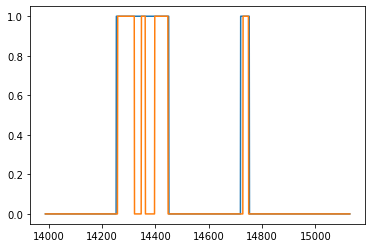

In [246]:
beh_df.query('trial==10')['off_track_event'].astype(int).plot()

beh_df.query('trial==10')['off_track'].astype(int).plot()

In [302]:
one_chunk = beh_df.query('trial==5')

In [303]:
# off_rows=one_chunk.loc[one_chunk['dist_to_maze']>3]
# off_rows=one_chunk.loc[one_chunk['dist_to_line']>3]
off_rows=one_chunk.loc[one_chunk['dist_to_line_usemean']>4]
# off_rows=one_chunk.loc[10290:10320]

In [304]:
off_rows

Time (s)         lin          x          y  trial  task_index  \
7515  6847.126800  119.706961  19.089622  13.469730    5.0           0   
7516  6847.160133  119.617636  18.990540  13.618150    5.0           0   
7517  6847.193467  119.528312  18.915037  13.642373    5.0           0   
7518  6847.226833  119.528312  18.869428  13.558187    5.0           0   
7519  6847.260167  119.528312  18.909224  13.517045    5.0           0   
7520  6847.293500  119.617636  18.996132  13.554166    5.0           0   
7521  6847.326833  119.706961  19.040987  13.560065    5.0           0   
7522  6847.360200  119.706961  19.043040  13.511770    5.0           0   
7523  6847.393533  119.706961  19.090908  13.470966    5.0           0   
7524  6847.426867  119.796285  19.184242  13.481163    5.0           0   
7525  6847.460200  119.974934  19.286592  13.442845    5.0           0   

             task  vx_gauss  vy_gauss  speed_gauss  ...   v_gauss  segment  \
7515  alternation -0.971420  2.096811     2.310903  ... -2.310903      2.0   
7516  alternation -0.639381  1.634331     1.754949  ... -1.754949      2.0   
7517  alternation -0.269738  1.131012     1.162732  ... -1.162732      2.0   
7518  alternation  0.137394  0.595608     0.611250  ...  0.611250      2.0   
7519  alternation  0.581584  0.038313     0.582844  ...  0.582844      2.0   
7520  alternation  1.062014 -0.529670     1.186770  ...  1.186770      2.0   
7521  alternation  1.577434 -1.096646     1.921179  ...  1.921179      2.0   
7522  alternation  2.126010 -1.650940     2.691750  ...  2.691750      2.0   
7523  alternation  2.705124 -2.181372     3.475065  ...  3.475065      2.0   
7524  alternation  3.311241 -2.677747     4.258479  ...  4.258479      2.0   
7525  alternation  3.939857 -3.131279     5.032632  ...  5.032632      2.0   

      dist_to_maze  off_track on_track  off_track_event  dist_to_line  \
7515      3.682748       True    False             True      3.959383   
7516      3.848017       True    False             True      4.107803   
7517      3.888101       True    False             True      4.132026   
7518      3.816952       True    False             True      4.047839   
7519      3.767495       True    False             True      4.006697   
7520      3.784287       True    False             True      4.043819   
7521      3.780851       True    False             True      4.049718   
7522      3.733124       True    False             True      4.001423   
7523      3.683715       True    False             True      3.960618   
7524      3.677071       True    False             True      3.970815   
7525      3.623515       True    False             True      3.932498   

      dist_to_line_usemean    vx_raw    vy_raw  
7515              4.044176 -3.450871  5.729733  
7516              4.192596 -2.645229  2.615803  
7517              4.216819 -1.835025 -0.908535  
7518              4.132632 -0.088074 -1.898916  
7519              4.091490  1.919753 -0.060910  
7520              4.128612  1.996406  0.651831  
7521              4.134511  0.710736 -0.642371  
7522              4.086216  0.756374 -1.349996  
7523              4.045412  2.139425 -0.463746  
7524              4.055609  2.964908 -0.426064  
7525              4.017291  1.846521 -3.826347  

[11 rows x 25 columns]

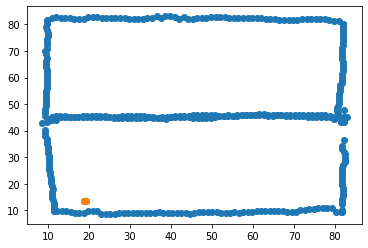

In [305]:
%matplotlib inline
plt.scatter(xy_sampled_filt_both[:,0],xy_sampled_filt_both[:,1])
plt.scatter(off_rows['x'],off_rows['y'])


In [10]:
beh_df=ba.detect_offtrack_event(beh_df,find_turns_kws={},off_track_thresh = 3.0,
            on_track_thresh = 1,edges_merge_time=0.4,st_ed_dist_thresh = 20.)

### get discrepancy of expected distance vs actual distance


In [170]:
beh_df['vx_raw'] = np.gradient(beh_df['x'])/dt
beh_df['vy_raw'] = np.gradient(beh_df['y'])/dt
beh_df['speed_raw'] = np.sqrt(beh_df['vx_raw']**2 + beh_df['vy_raw']**2)

In [16]:
def get_expected_displacement(speed_sub,dt=0.0333):
    
    expected_displacement = speed_sub[1:].sum() * dt
    return expected_displacement

def get_actual_displacement(xy_sub):
#     actual_displacement = np.sum(np.linalg.norm(np.diff(sub_df[:,:2],axis=0),axis=1))
#     actual_displacement = np.sum(np.linalg.norm(np.diff(xy_sub,axis=0),axis=1))
    actual_displacement = np.linalg.norm(xy_sub[-1] - xy_sub[0])
    return actual_displacement

In [25]:
win_time = 1.#0.5
dt = 0.033
win_nbins= int(win_time / dt)

speed_key ='speed_raw'#'speed_gauss'
xy_l = beh_df[['x','y']].values
# xy_l = beh_df['lin'].values
speed_l = beh_df[speed_key].values
actual_dis_l = []
exp_dis_l = []
for i in range(win_nbins,xy_l.shape[0]):
    actual_dis = get_actual_displacement(xy_l[(i-win_nbins):i])
    exp_dis = get_expected_displacement(speed_l[(i-win_nbins):i],dt=dt)
    actual_dis_l.append(actual_dis)
    exp_dis_l.append(exp_dis)
    
beh_df['actual_disp'] =  np.insert(actual_dis_l,0,[np.nan] * win_nbins)
beh_df['expected_disp'] = np.insert(exp_dis_l,0,[np.nan] * win_nbins)

beh_df['expected_minus_actual_disp'] = beh_df['expected_disp'] - beh_df['actual_disp']

In [38]:
peak_thresh = 4
trough_thresh = 10. # first try no trough thresh
peaks = scipy.signal.find_peaks(beh_df['expected_minus_actual_disp'],height=peak_thresh)[0]
troughs = scipy.signal.find_peaks(-beh_df['expected_minus_actual_disp'],height=-trough_thresh)[0]

In [49]:
prev_troughs = []
for p in peaks:
    troughs_sub = troughs[troughs<p] 
    t = troughs_sub[-1]
    prev_troughs.append(t)
not_locomotion_edges = np.stack([prev_troughs,peaks],axis=1)
not_locomotion_l = np.zeros(beh_df.shape[0],dtype=bool)
for t,p in not_locomotion_edges:
    not_locomotion_l[t:(p+1)] = True
beh_df['not_locomotion'] = not_locomotion_l

<AxesSubplot:>

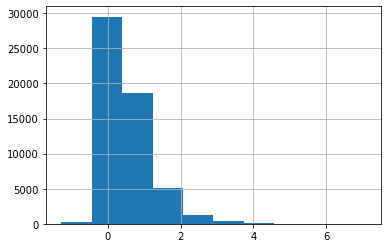

In [19]:
%matplotlib inline
(beh_df['expected_disp'] - beh_df['actual_disp']).hist()

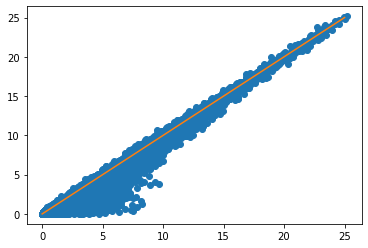

In [182]:
plt.scatter(exp_dis_l,actual_dis_l)
plt.plot([0,25],[0,25],color='C1')

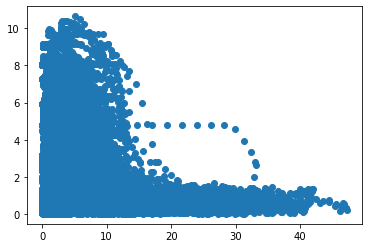

In [141]:
%matplotlib inline
plt.scatter(beh_df['speed_gauss'],beh_df['dist_to_maze'])

In [130]:
%%time
# get on off track based on an iqr test
highspeed_thresh = 5.
beh_df_highspeed = beh_df.loc[beh_df['speed_gauss'] > highspeed_thresh]
buffer_time = 4
dt = 0.033
buffer_nbins = int(buffer_time / dt)
off_track_l = []
on_track_l = []
for k,row in beh_df.iterrows():
    if k<buffer_nbins:
        dist_buffer = beh_df_highspeed.loc[:buffer_nbins]['dist_to_maze']
    else:
        dist_buffer = beh_df_highspeed.loc[(k-buffer_nbins):k]['dist_to_maze']
    
    
    dist_buffer_low = np.quantile(dist_buffer,0.25)
    dist_buffer_high = np.quantile(dist_buffer,0.75)
    iqr = dist_buffer_high-dist_buffer_low
    ci_high = dist_buffer_high+iqr / 2
    off_track = row['dist_to_maze'] > ci_high
    off_track_l.append(off_track)
    on_track = row['dist_to_maze'] <= dist_buffer_high
    on_track_l.append(on_track)
beh_df['off_track_iqr'] = off_track_l
beh_df['on_track_iqr'] = on_track_l



IndexError: index -1 is out of bounds for axis 0 with size 0

In [206]:
(beh_df['expected_minus_actual_disp'] > 2).sum()


2096

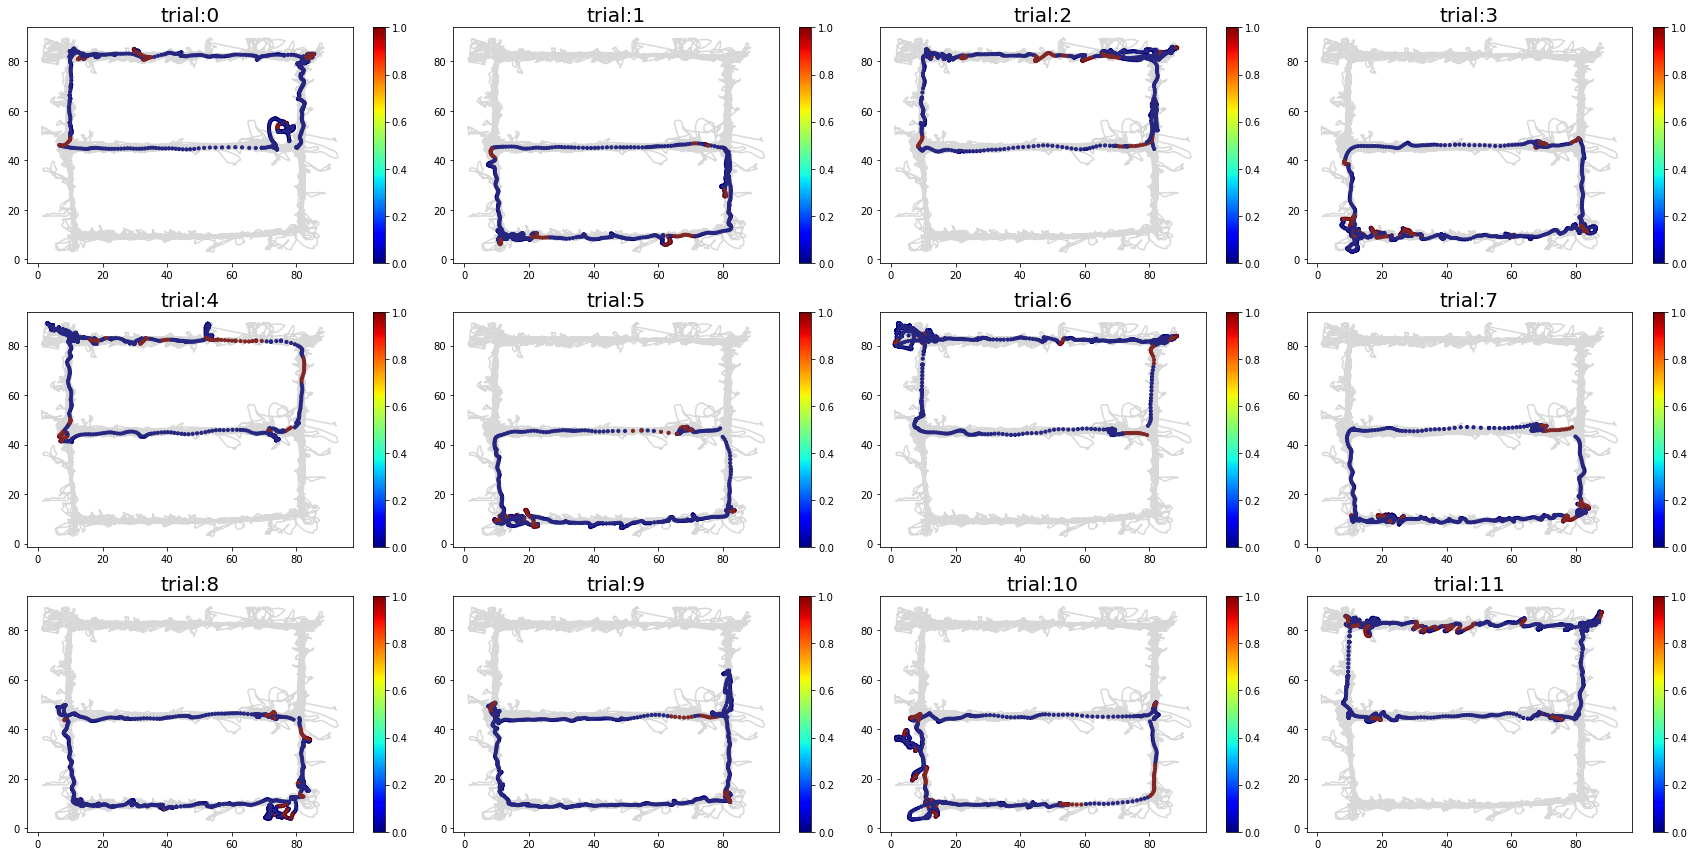

In [50]:
# NOT LOCOMOTION, trough to peak in expected_minus_actual_disp
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df.query('trial==@tr')
    colors = one_chunk['not_locomotion'].astype(int)
    fig,ax=ba.plot_one_headscan(beh_df,one_chunk,colors=colors,fig=fig,ax=ax)
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

In [29]:
beh_df['not_locomotion'] = beh_df['expected_minus_actual_disp'] > 4

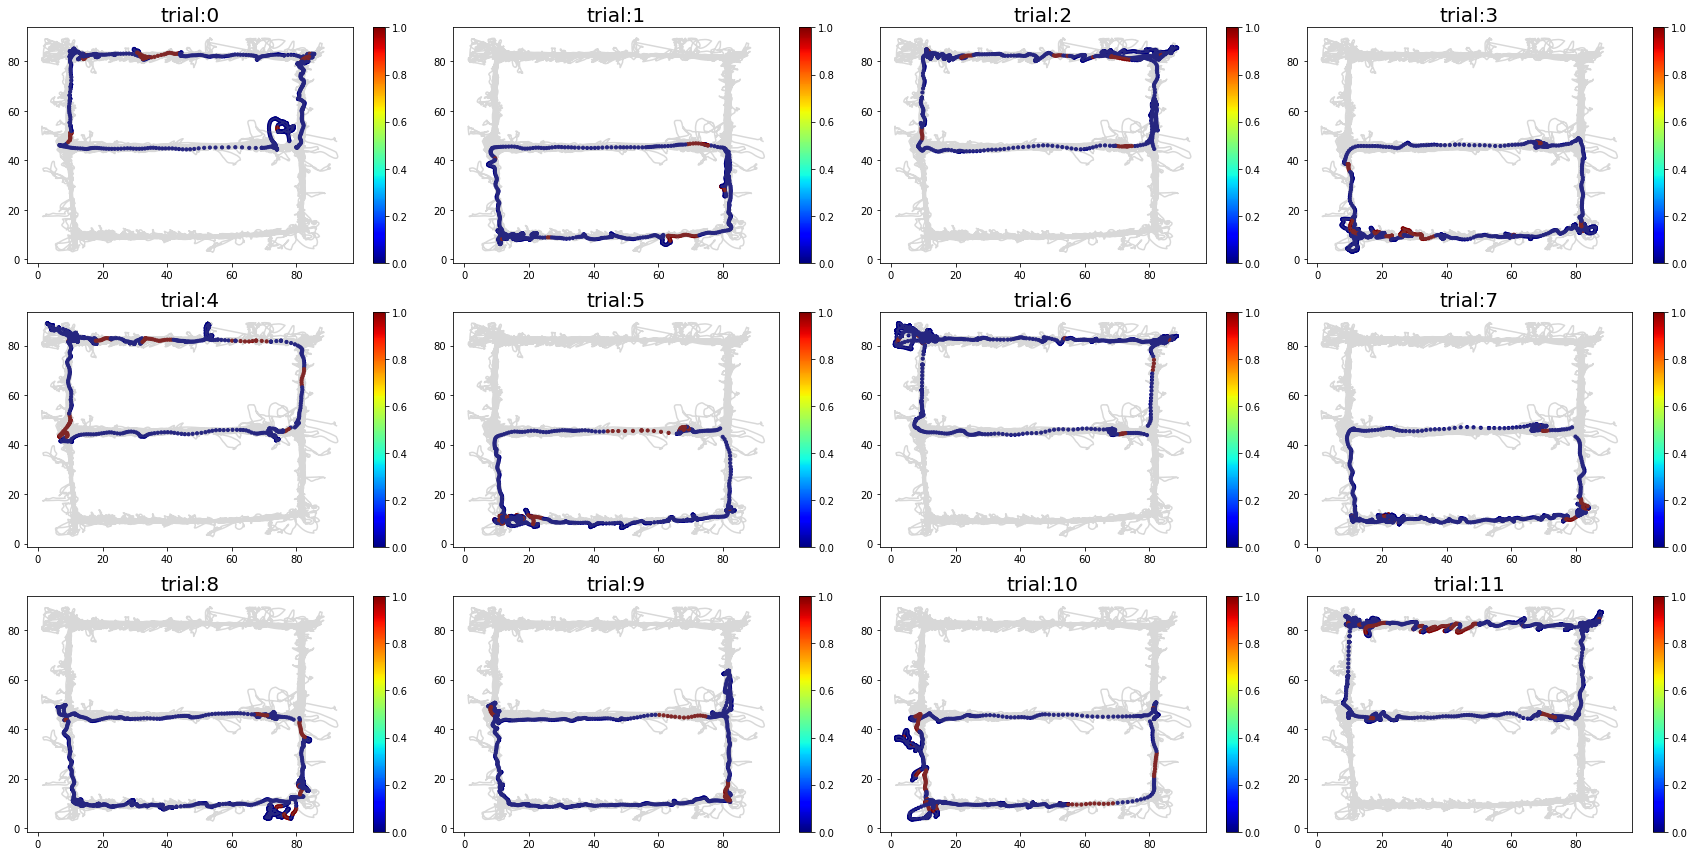

In [30]:
# NOT LOCOMOTION
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df.query('trial==@tr')
    colors = one_chunk['not_locomotion'].astype(int)
    fig,ax=ba.plot_one_headscan(beh_df,one_chunk,colors=colors,fig=fig,ax=ax)
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

<AxesSubplot:>

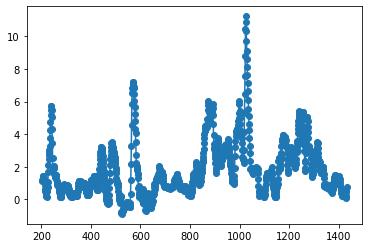

In [32]:
beh_df.query('trial==0')['expected_minus_actual_disp'].plot(marker='o')

<AxesSubplot:>

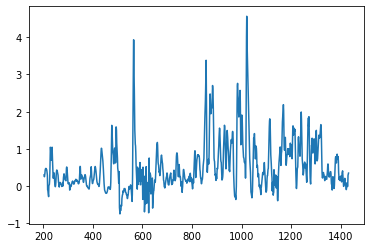

In [24]:
beh_df.query('trial==0')['expected_minus_actual_disp'].plot()

<IPython.core.display.Javascript object>


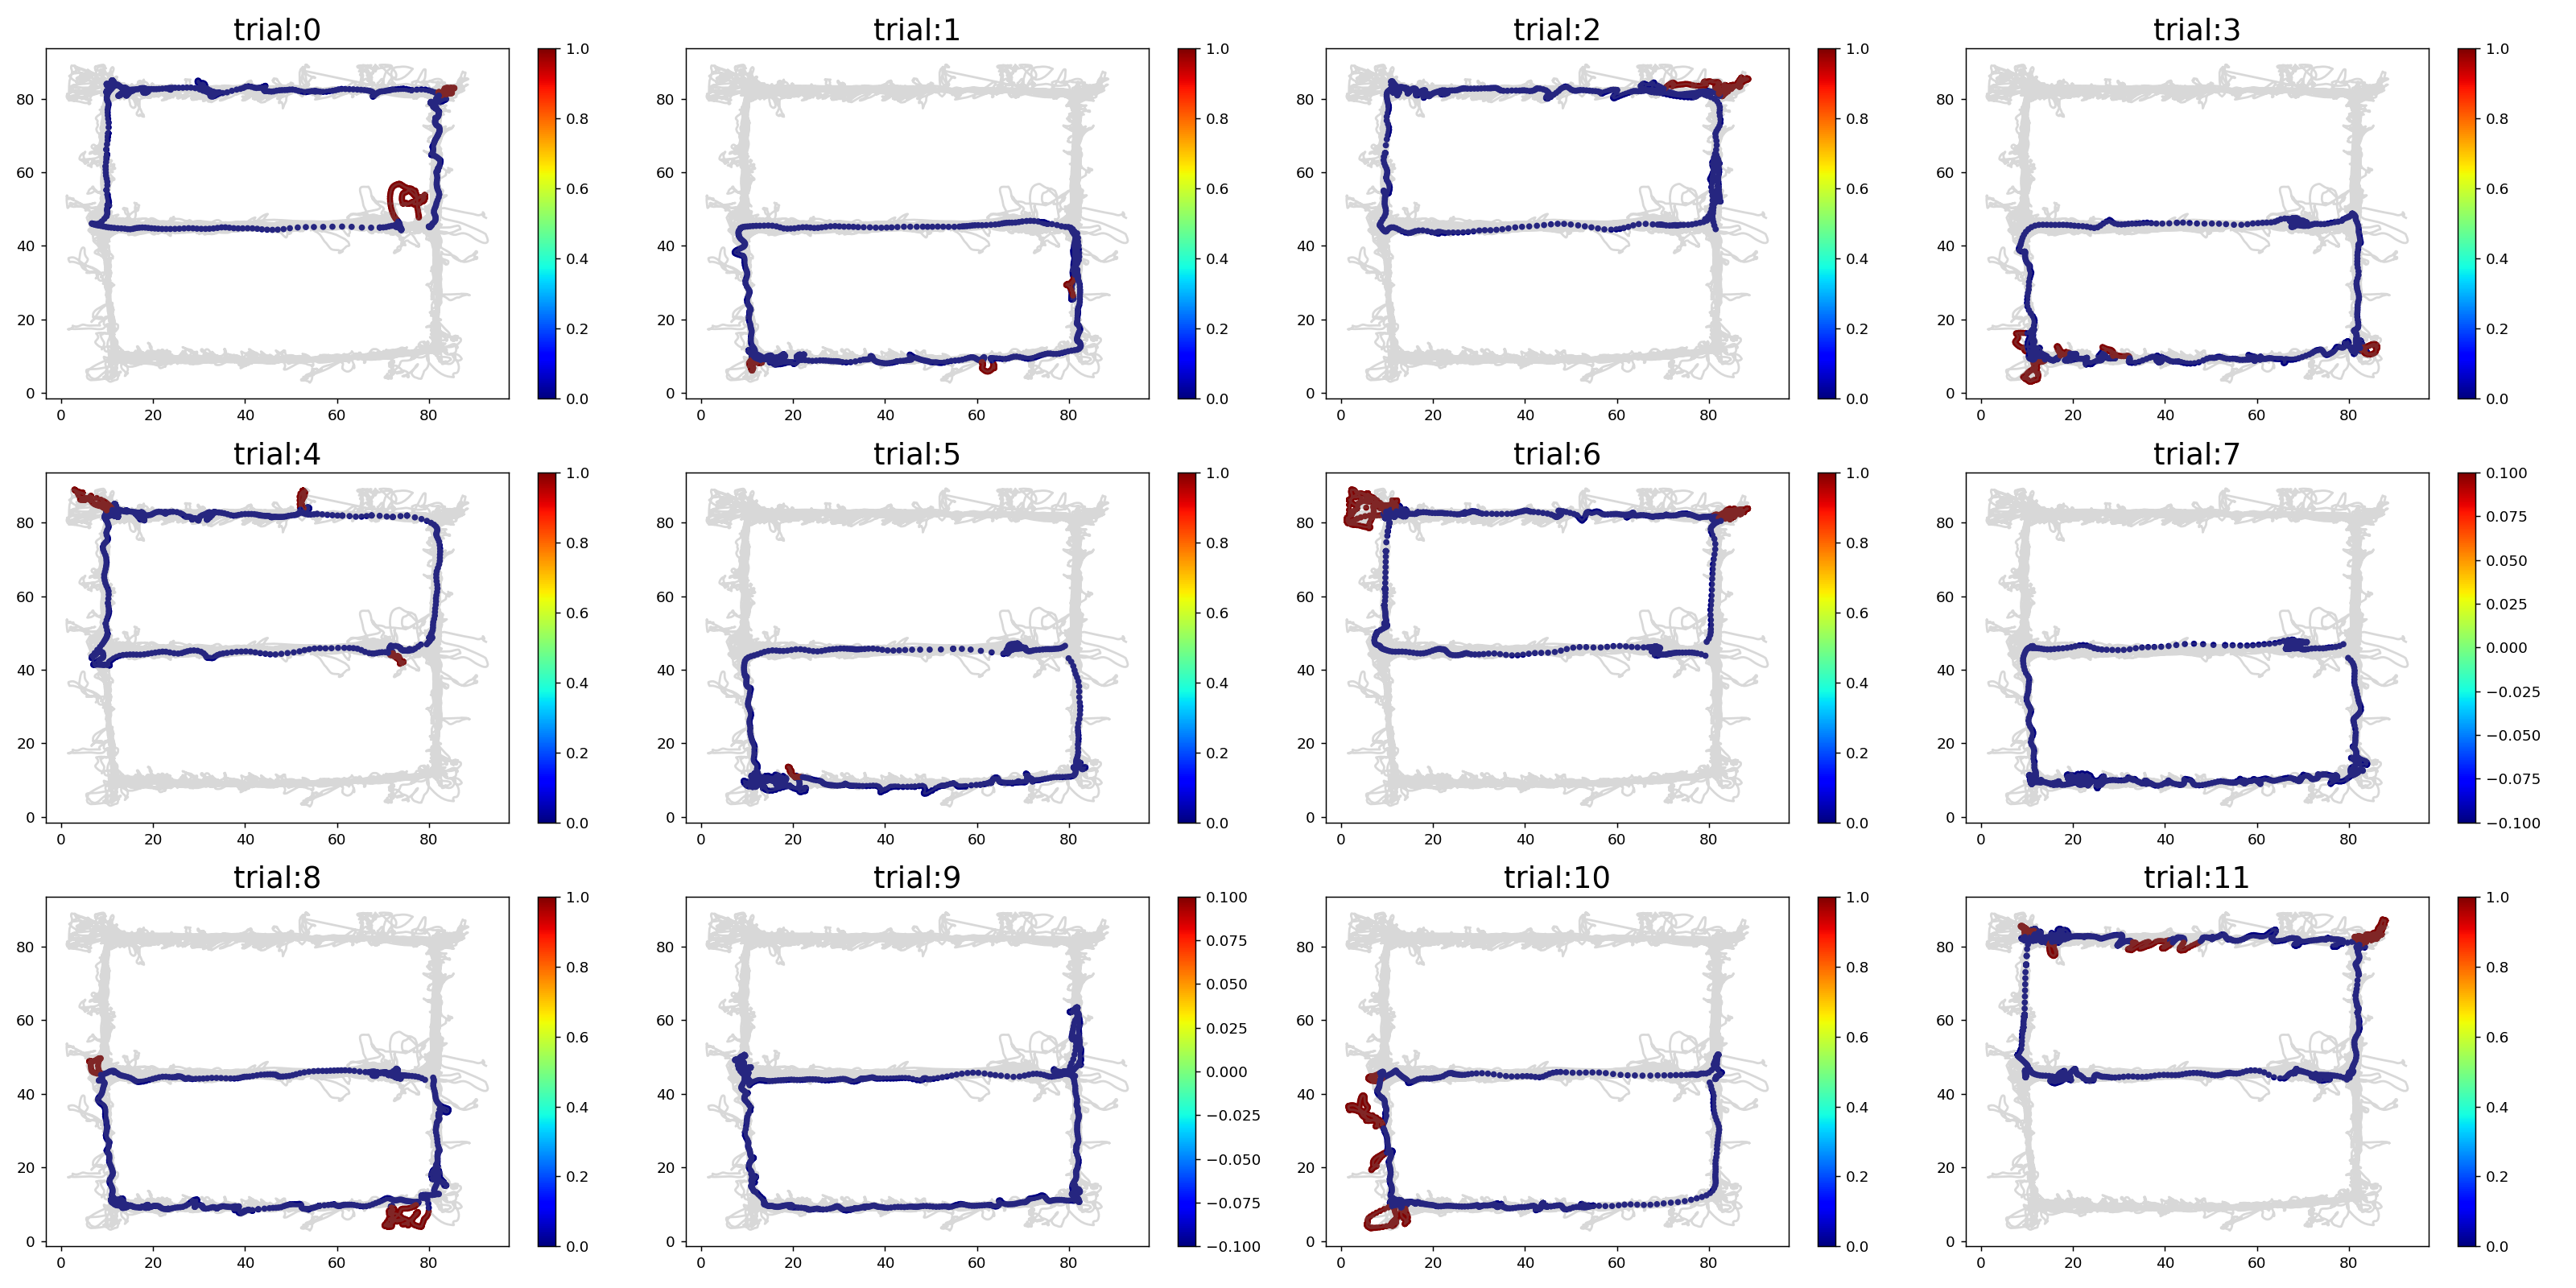

In [11]:
%matplotlib notebook
# off track event
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df.query('trial==@tr')
    colors = one_chunk['off_track_event'].astype(int)
    fig,ax=ba.plot_one_headscan(beh_df,one_chunk,colors=colors,fig=fig,ax=ax)
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

<IPython.core.display.Javascript object>


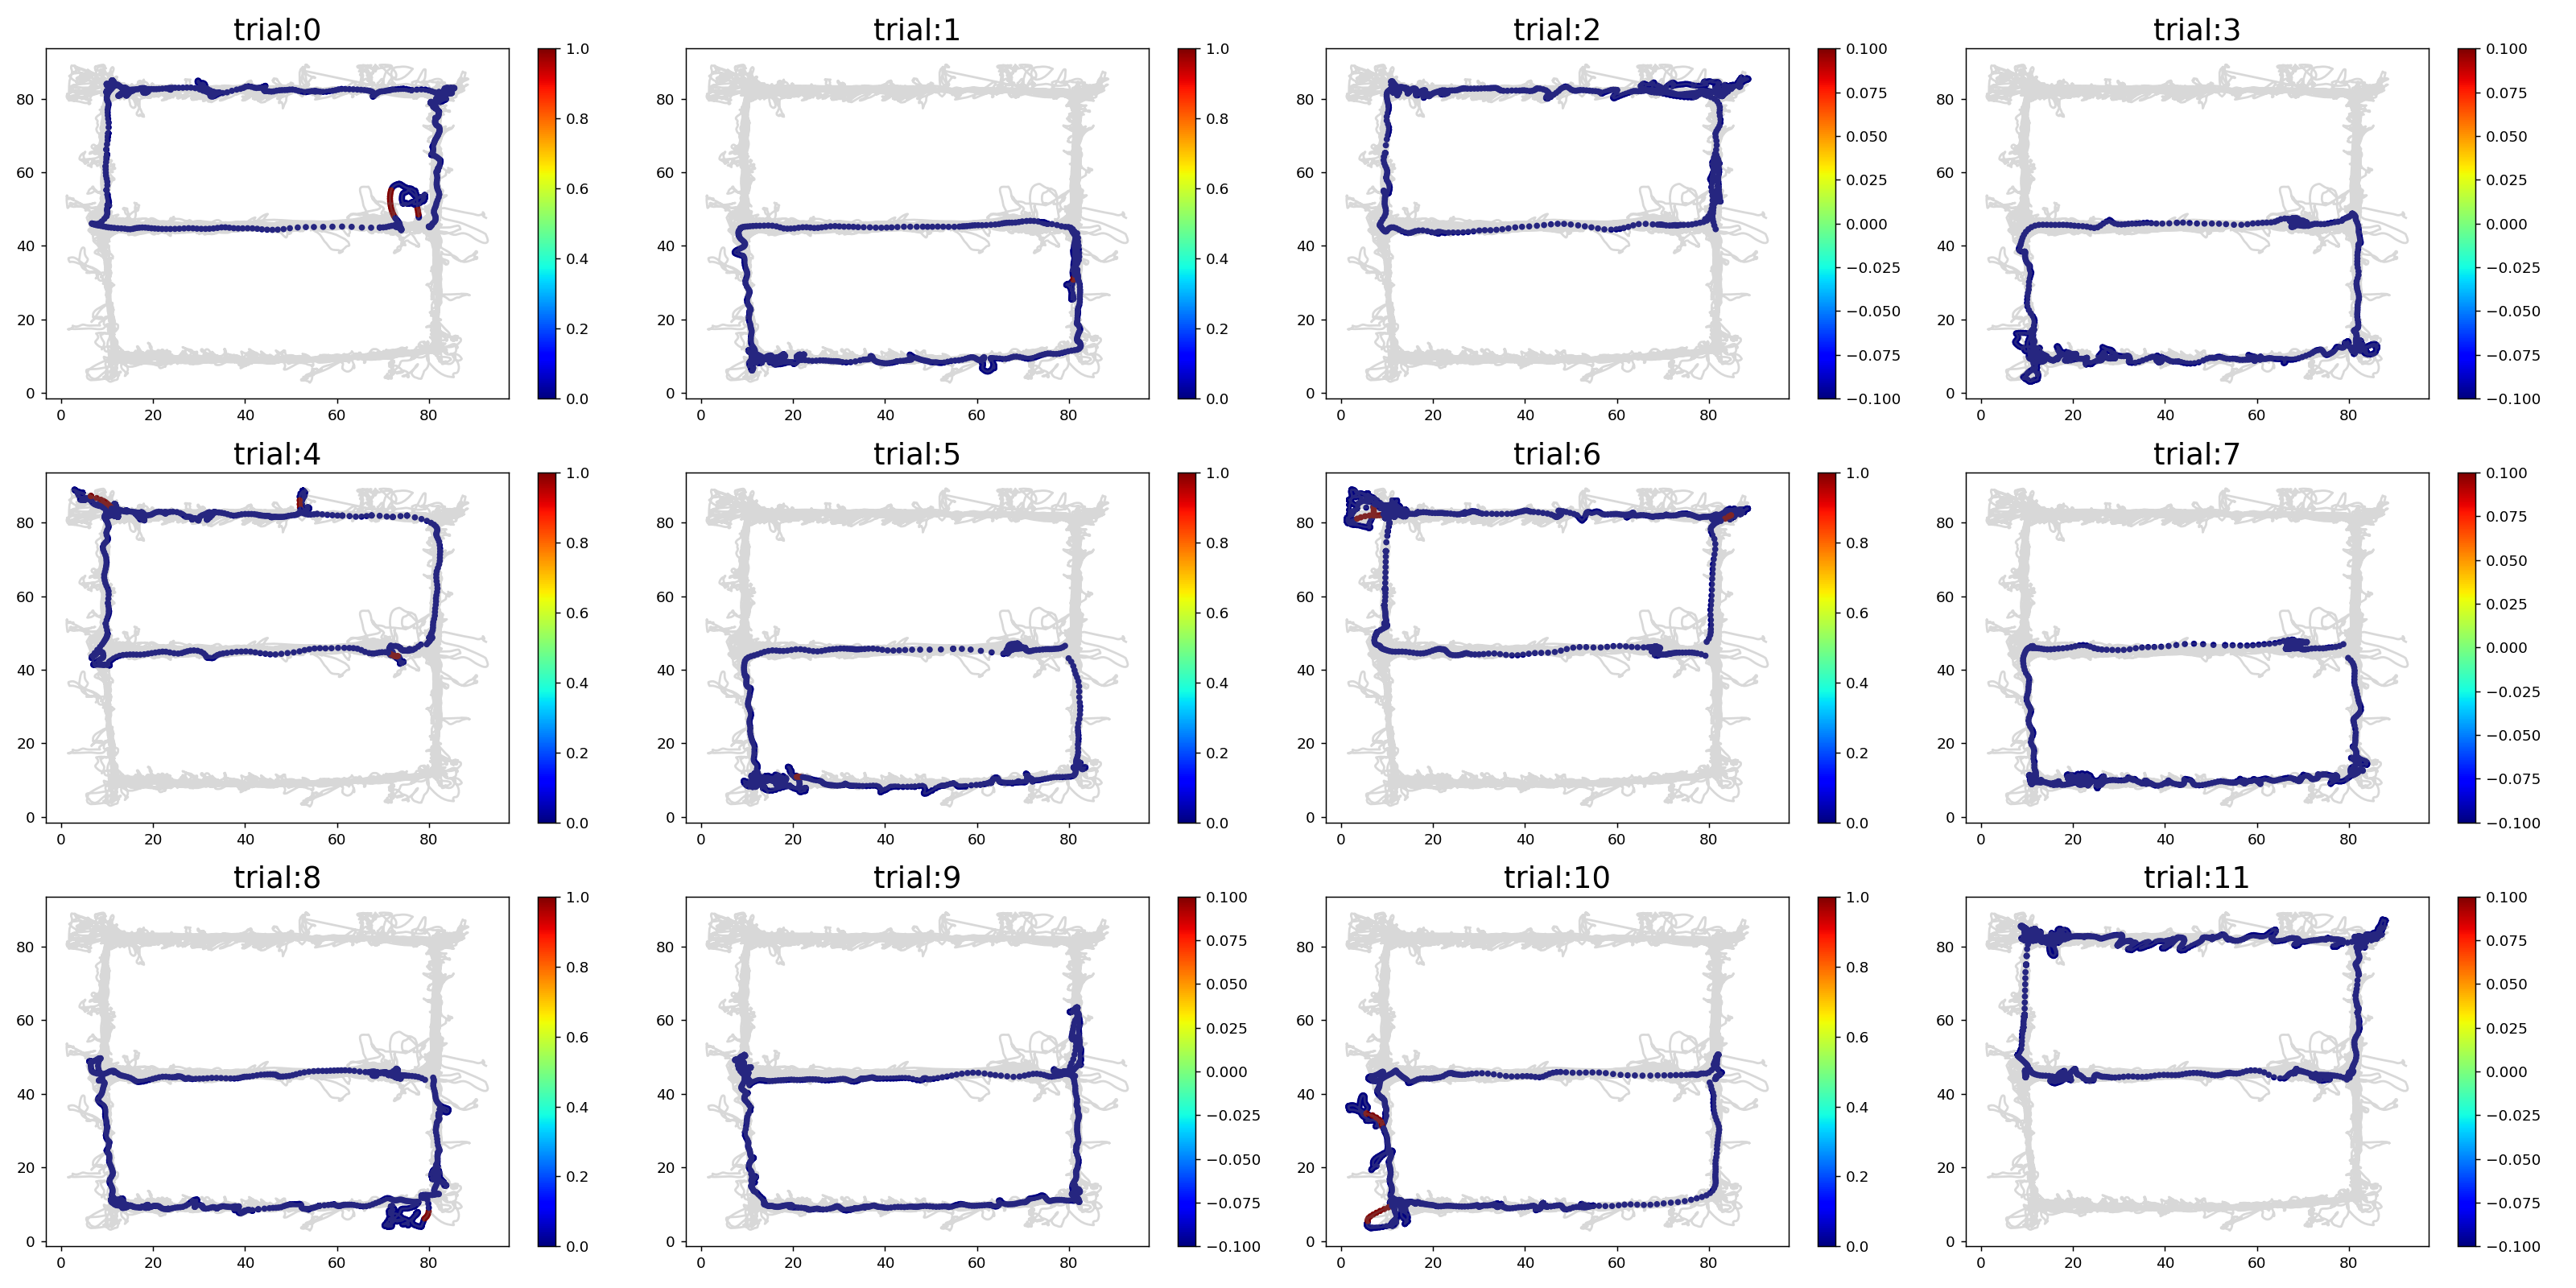

In [15]:
%matplotlib notebook
# off track event + speed criterion 
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df.query('trial==@tr')
    colors = (one_chunk['off_track_event'] & (one_chunk['speed_gauss']>10)).astype(int)
    fig,ax=ba.plot_one_headscan(beh_df,one_chunk,colors=colors,fig=fig,ax=ax)
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

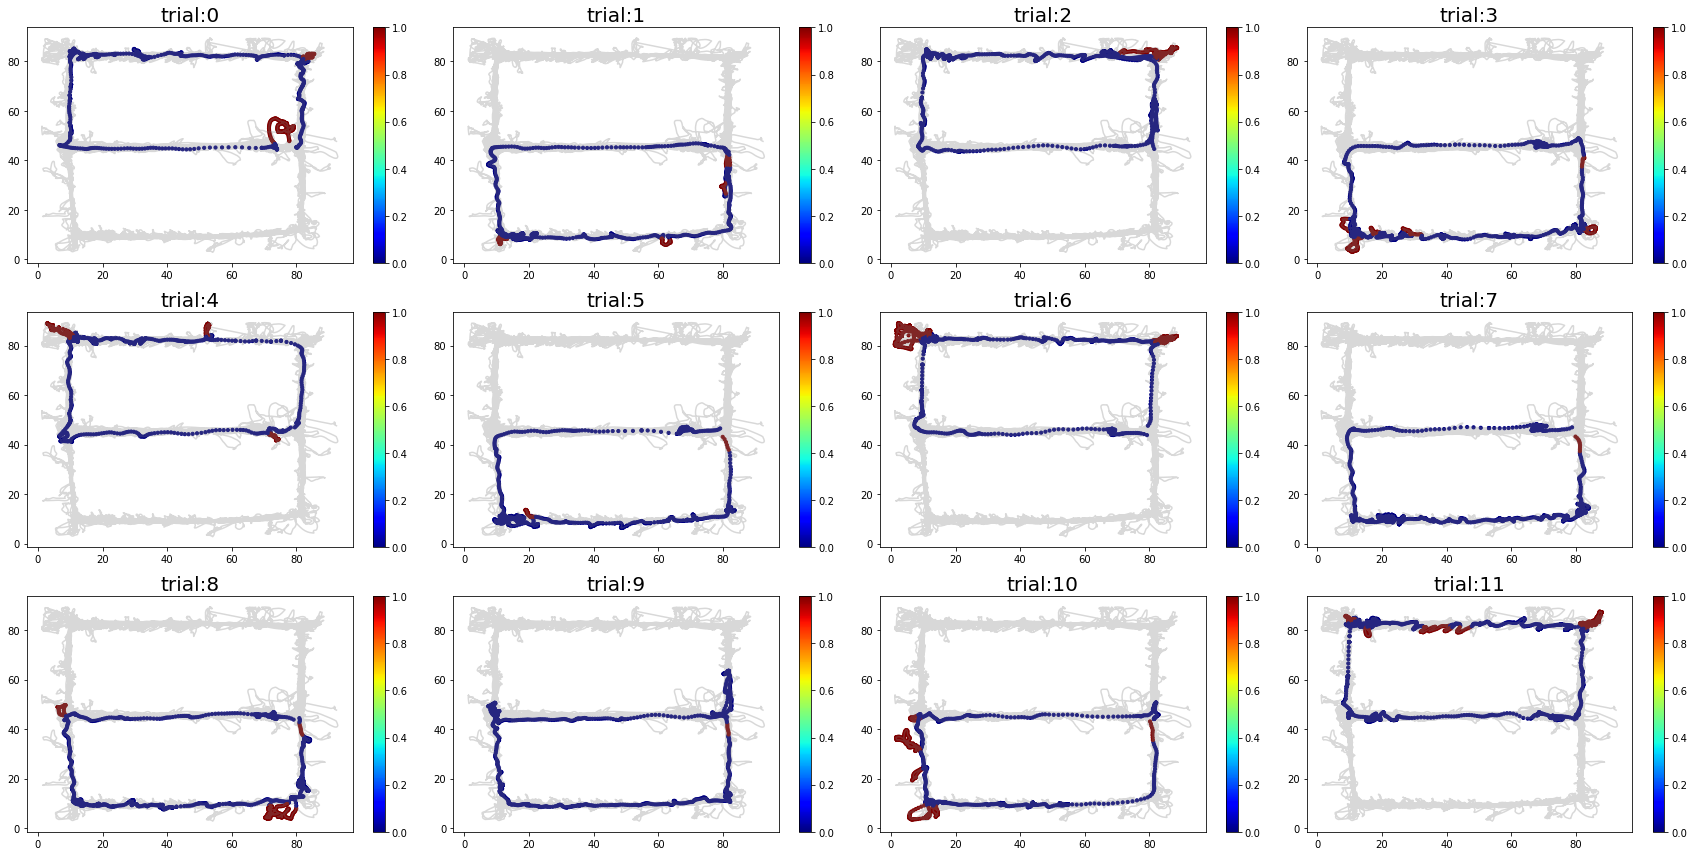

In [30]:
# off track event
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df.query('trial==@tr')
    colors = one_chunk['off_track_event'].astype(int)
    fig,ax=ba.plot_one_headscan(beh_df,one_chunk,colors=colors,fig=fig,ax=ax)
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

In [37]:
beh_df.query('trial==7')[-100:]['dist_to_maze']>3

11454    False
11455    False
11456    False
11457    False
11458    False
         ...  
11549    False
11550    False
11551    False
11552    False
11553    False
Name: dist_to_maze, Length: 100, dtype: bool

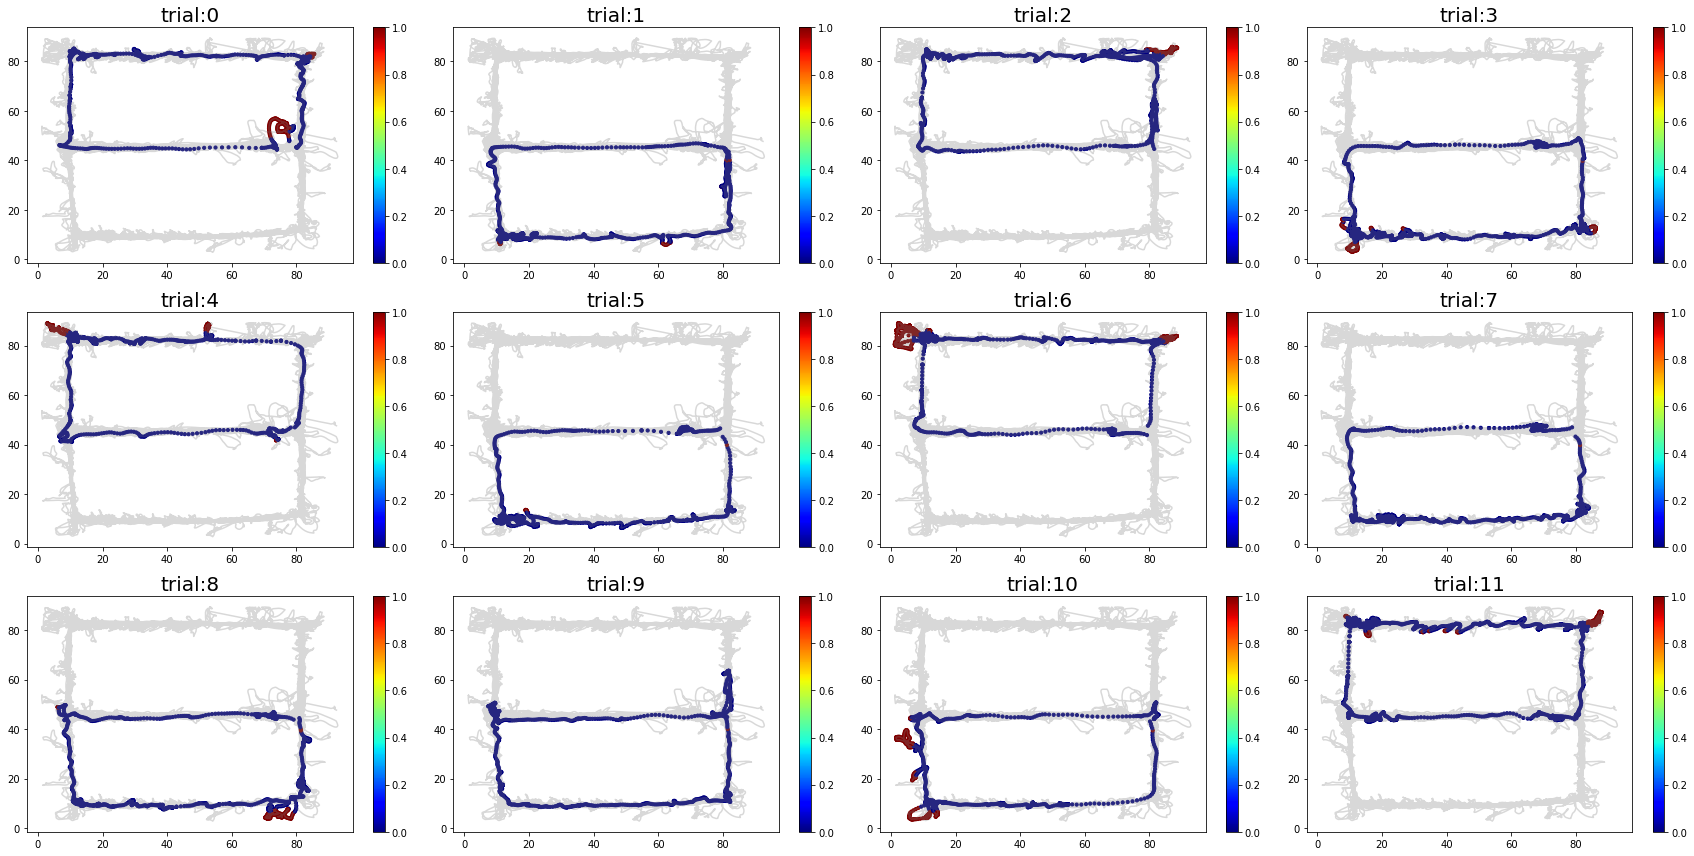

In [343]:
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df.query('trial==@tr')
    colors = one_chunk['dist_to_maze'] > 3
    fig,ax=ba.plot_one_headscan(beh_df,one_chunk,colors=colors,fig=fig,ax=ax)
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

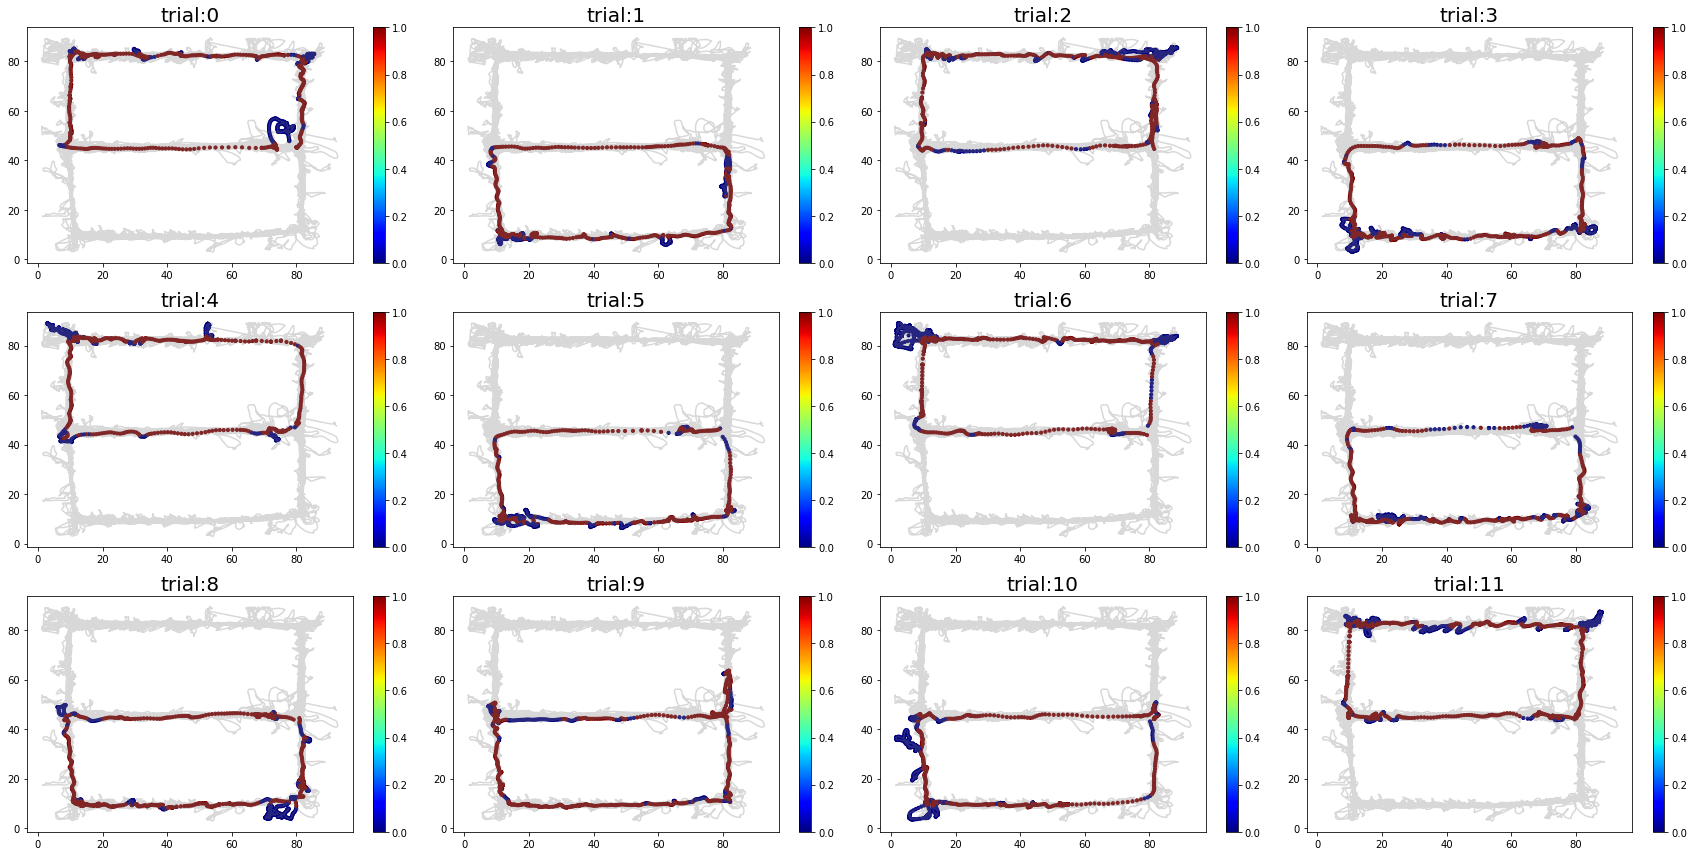

In [356]:
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df.query('trial==@tr')
    colors = one_chunk['dist_to_maze'] <= 1
    fig,ax=ba.plot_one_headscan(beh_df,one_chunk,colors=colors,fig=fig,ax=ax)
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

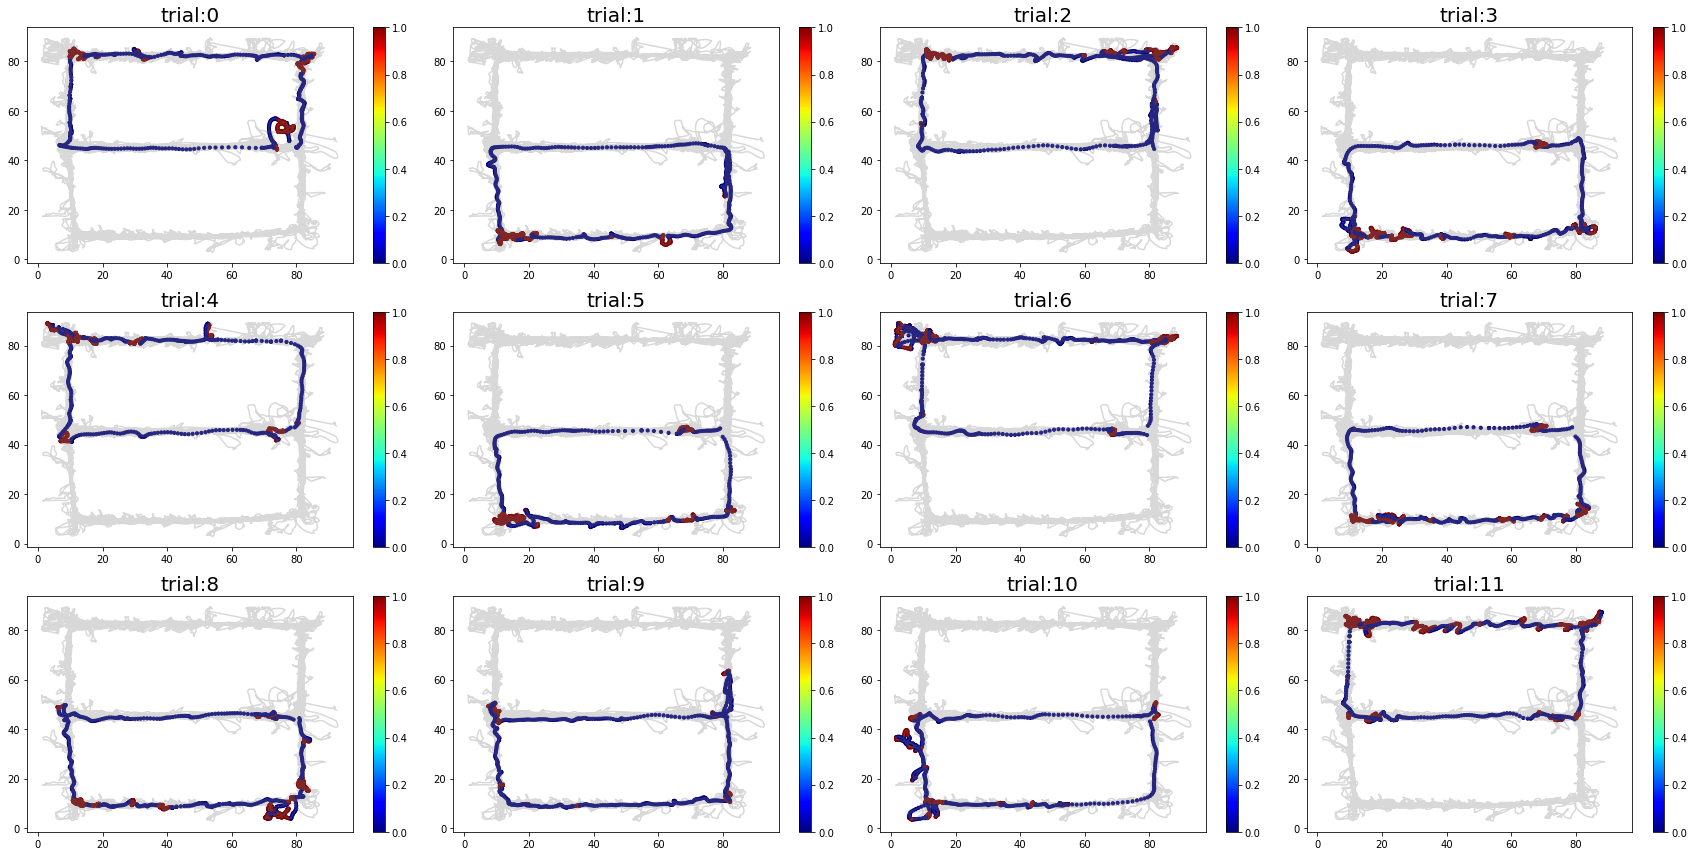

In [344]:
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df.query('trial==@tr')
    colors = one_chunk['speed_gauss'] <5
    fig,ax=ba.plot_one_headscan(beh_df,one_chunk,colors=colors,fig=fig,ax=ax)
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

<IPython.core.display.Javascript object>


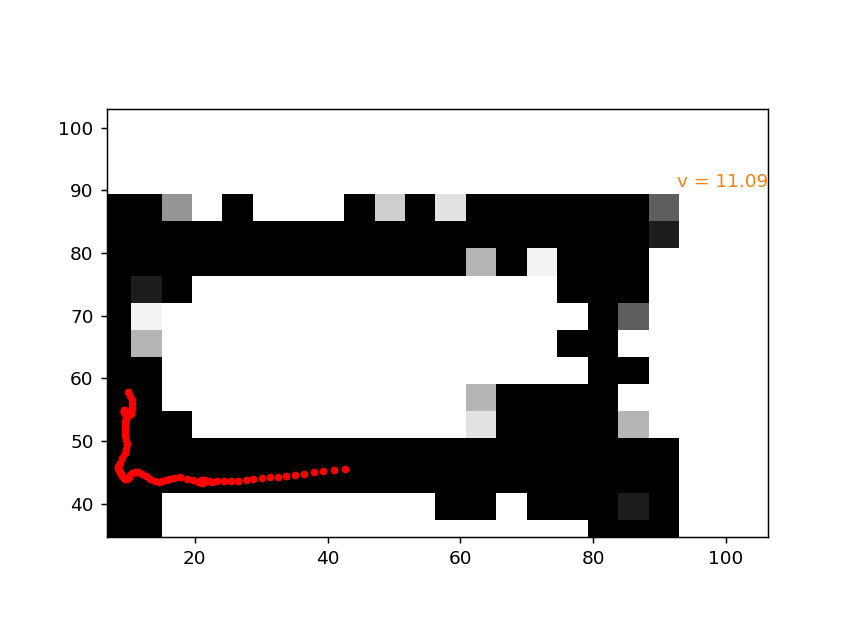

In [106]:
%matplotlib notebook
# %%time
beh_df_sub = beh_df
import animate_helper as ah
reload(ah)
tr=2
one_chunk = beh_df_sub.query('trial==@tr')
data = one_chunk[['x','y']].values.T
x_all = beh_df_sub['x'].values
y_all = beh_df_sub['y'].values
speed_l = one_chunk['speed_gauss'].values
save_dir = os.path.join(data_dir_full,'py_figures','behavior')
DO_SAVE=False

save_fn = f'behavior_trial{tr}.mp4'

fig,ax,ani=ah.animate_movement_in_maze(data,x_all,y_all,hist2d_kws={},ax_kws={},fig=None,ax=None,
                                    animate_kws={'interval':30},dosave=DO_SAVE,
                                    do_plot_background_maze=True,
                                    n_tail=100,trial_l=None,speed_l=speed_l,
                                    save_dir=save_dir,save_fn=save_fn
                                )